In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
import networkx as nx
import scipy
import re

from glob import glob
import nxviz
from nxviz.plots_cust import CircosPlot, MatrixPlot, ArcPlot, BasePlot

In [2]:
dist_groups = np.array([[0, 15], [15, 30], [30, 5000]])
dist_labels = ['local (<15 mm)', 'short (<30mm)', 'long']

Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

#dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((4, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
color_elab[3, :] = np.array([1, 0.574, 0])

## 1. get all connection data

In [3]:
folder = 'BrainMapping'
cond_folder = 'CR'
subjs = ['EL019','EL010', 'EL011', 'EL015', 'EL014','EL016', 'EL017']# ['EL019', 'EL017', 'EL011', 'EL015', 'EL014', 'EL016']
#

In [4]:

path = 'y:\eLab\Patients\\'  # + subj
CR_color = pd.read_excel("T:\EL_experiment\Patients\\" + 'all' + "\Analysis\BrainMapping\CR_color.xlsx",
                         header=0)
regions = pd.read_excel("Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\elab_labels.xlsx",
                        sheet_name='regions',
                        header=0)


sep = ';'
color_regions = regions.color.values
C = regions.label.values
cond_folder = 'CR'

# In - Out Degree

In [5]:
data_con_file = 'Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\Sleep\\data_con_subj.csv'
if os.path.exists(data_con_file):
    data_con_subj = pd.read_csv(data_con_file)
else:
    for i in range(len(subjs)):
        print('loading -- ' + subjs[i], end='\r')
        subj = subjs[i]
        path_gen = os.path.join('y:\\eLab\Patients\\' + subj)
        if not os.path.exists(path_gen):
            path_gen = 'T:\\EL_experiment\\Patients\\' + subj
        path_patient = path_gen + '\Data\EL_experiment'
        path_infos = os.path.join(path_patient, 'infos')
        if not os.path.exists(path_infos):
            path_infos = path_gen + '\\infos'
        path_patient_analysis = 'y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj

        file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
        con_trial = pd.read_csv(file_con)

        lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
        labels_all = lbls.label.values
        labels_clinic = lbls.Clinic.values
        labels_region = lbls.Region.values
        labels_region[labels_region == 'HIPP'] = 'Mesiotemporal'
        labels_region[labels_region == 'HIPP '] = 'Mesiotemporal'
        labels_region[labels_region == 'ENT'] = 'Basotemporal'
        bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

        # data_A = data_A[~np.isin(data_A.Chan,bad_all)&~np.isin(data_A.Stim,bad_all)]
        
        con_trial = con_trial[con_trial.Sig>=0]
        con_trial = con_trial.reset_index(drop=True)
        con_trial.loc[con_trial.SleepState=='W','SleepState'] = 'Wake'
        con_trial.insert(3,'LLs', con_trial.LL*con_trial.Sig)
        con_trial.insert(3,'StimR', 'u')
        con_trial.insert(3,'ChanR', 'u')
        con_trial.insert(0,'Subj', subj)
        for c in range(len(labels_all)):
            con_trial.loc[con_trial.Chan==c,'ChanR']= labels_region[c]
            con_trial.loc[con_trial.Stim==c,'StimR']= labels_region[c]
            
        if i == 0:
            data_con_subj = con_trial
        else:
            data_con_subj = pd.concat([data_con_subj, con_trial])
            data_con_subj = data_con_subj.reset_index(drop=True)
        
    data_con_subj.to_csv(data_con_file,
        header=True, index=False)

In [6]:
data_con_subj.insert(5,'SS', data_con_subj.SleepState)

### Surrogate

In [14]:
data_con_surr = 'Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\Sleep\degree\\data_con_surr.csv'
if os.path.exists(data_con_file):
    deg_surr = pd.read_csv(data_con_surr)
else:
    
    n = 200
    surr_data = np.zeros((len(G_deg),n))
    for i in range(0,n):
        print('loading -- ' + str(i+1)+'/'+str(n), end='\r')
        data_con_subj["SS"] = data_con_subj.groupby(['Subj','Stim','Chan'], as_index=False)["SS"].transform(np.random.permutation)
        G = data_con_subj.groupby(['Subj','Stim','Chan','ChanR','StimR','SS'], as_index=False)[['Sig','LLs', 'd']].mean()
        metrics = ['LLs']
        # degrees: sum up all CCEP magnitudes with specific channel being reponse or stimulation channel
        G_in = G.groupby(['Subj','Chan','ChanR','SS'], as_index=False)[metrics].sum()
        G_in.insert(3,'Deg', 'in')
        G_out = G.groupby(['Subj','Stim','StimR','SS'], as_index=False)[metrics].sum()
        G_out.insert(3,'Deg', 'out')
        G_out.insert(0,'Chan', G_out.Stim)
        G_out.insert(0,'ChanR', G_out.StimR)
        G_deg_surr = pd.concat([G_in,G_out])
        G_deg_surr = G_deg_surr.reset_index(drop=True)
        G_deg_surr = G_deg_surr.drop(columns=['Stim'])
        G_deg_surr = G_deg_surr.drop(columns=['StimR'])
        for m in metrics:
            means_stds = G_deg_surr.groupby(['Subj','Chan','Deg','SS'])[m].agg(['mean','std']).reset_index()
            means_stds = means_stds[means_stds.SS=='Wake']
            means_stds = means_stds.drop(columns=['SS'])
            G_deg_surr = G_deg_surr.merge(means_stds,on=['Subj','Chan','Deg'])
            G_deg_surr[m+'_n'] = (G_deg_surr[m] / G_deg_surr['mean']) 
            G_deg_surr = G_deg_surr.drop(columns=['mean', 'std'])
        #surr_data[:,i] =G_deg_surr.values[:,-1]
        G_deg_surr.insert(1, 'Lobe', G_deg_surr.ChanR)
        for region in np.unique(G_deg_surr[['ChanR']]):
            if len(regions.Lobe[regions.label==region].values)>0:
                lobe = regions.Lobe[regions.label==region].values[0]
            else:
                lobe = 'out'
            G_deg_surr.loc[G_deg_surr.ChanR==region, 'Lobe'] = lobe

        deg_summary = G_deg_surr[(G_deg_surr.Lobe != 'Unknown')&(G_deg_surr.Lobe != 'out')&(G_deg_surr.SS != 'Wake')]
        deg_summary = deg_summary.reset_index(drop=True)
        deg_summary = deg_summary.groupby(['Lobe', 'Deg', 'SS'], as_index=False)['LLs_n'].mean()
        deg_summary.insert(deg_summary.shape[1], str(i+1), deg_summary.LLs_n)
        deg_summary = deg_summary.drop(columns='LLs_n')
        if i == 0:
            deg_surr = deg_summary
        else:
            deg_surr = deg_surr.merge(deg_summary, on=['Lobe','Deg', 'SS'])
    deg_surr.to_csv(data_con_surr,
            header=True, index=False)

g = sns.catplot(x ='Lobe', y='LLs_n', hue='SS', data= G_deg_surr[(G_deg_surr.Lobe != 'Unknown')&(G_deg_surr.Lobe != 'out')&(G_deg.SleepState != 'Wake')], row = 'Deg', kind='violin',s=5,height=8,aspect= 4)
ax = g.axes  # access a grid of 'axes' objects
plt.ylim([0.5,2])
ax[0,0].axhline(1, color='k', linewidth=2)
ax[1,0].axhline(1, color='k', linewidth=2)
plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\Sleep\degree\\Deg_Lobe_surr.svg')

### Real

In [15]:
G = data_con_subj.groupby(['Subj','Stim','Chan','ChanR','StimR','SleepState'], as_index=False)[['Sig','LLs', 'd']].mean()
metrics = ['Sig','LLs']
# degrees: sum up all CCEP magnitudes with specific channel being reponse or stimulation channel
G_in = G.groupby(['Subj','Chan','ChanR','SleepState'], as_index=False)[metrics].sum()
G_in.insert(3,'Deg', 'in')
G_out = G.groupby(['Subj','Stim','StimR','SleepState'], as_index=False)[metrics].sum()
G_out.insert(3,'Deg', 'out')
G_out.insert(0,'Chan', G_out.Stim)
G_out.insert(0,'ChanR', G_out.StimR)
G_deg = pd.concat([G_in,G_out])
G_deg = G_deg.reset_index(drop=True)
G_deg = G_deg.drop(columns=['Stim'])
G_deg = G_deg.drop(columns=['StimR'])
for m in metrics:
    means_stds = G_deg.groupby(['Subj','Chan','Deg','SleepState'])[m].agg(['mean','std']).reset_index()
    means_stds = means_stds[means_stds.SleepState=='Wake']
    means_stds = means_stds.drop(columns=['SleepState'])
    G_deg = G_deg.merge(means_stds,on=['Subj','Chan','Deg'])
    G_deg[m+'_n'] = (G_deg[m] / G_deg['mean']) 
    G_deg = G_deg.drop(columns=['mean', 'std'])
    
G_deg.insert(1, 'Lobe', G_deg.ChanR)
for region in np.unique(G_deg[['ChanR']]):
    if len(regions.Lobe[regions.label==region].values)>0:
        lobe = regions.Lobe[regions.label==region].values[0]
    else:
        lobe = 'out'
    G_deg.loc[G_deg.ChanR==region, 'Lobe'] = lobe

deg_summary = G_deg[(G_deg.Lobe != 'Unknown')&(G_deg.Lobe != 'out')&(G_deg.SleepState != 'Wake')]
deg_summary = deg_summary.reset_index(drop=True)
deg_summary = deg_summary.groupby(['Lobe', 'Deg','SleepState'], as_index=False)['LLs_n'].mean()

deg_summary.insert(3,'thr_H', np.percentile(deg_surr.values[:,3:],99,1))
deg_summary.insert(3,'thr_L', np.percentile(deg_surr.values[:,3:],1,1))
deg_summary.insert(3,'Sig', (deg_summary.LLs_n<deg_summary.thr_L)|(deg_summary.LLs_n>deg_summary.thr_H))

In [ ]:
G = data_con_subj.groupby(['Subj','Stim','Chan','ChanR','StimR','SleepState'], as_index=False)[['Sig','LLs', 'd']].mean()
metrics = ['Sig','LLs']
# degrees: sum up all CCEP magnitudes with specific channel being reponse or stimulation channel
G_in = G.groupby(['Subj','Chan','ChanR','SleepState'], as_index=False)[metrics].sum()
G_in.insert(3,'Deg', 'in')
G_out = G.groupby(['Subj','Stim','StimR','SleepState'], as_index=False)[metrics].sum()
G_out.insert(3,'Deg', 'out')
G_out.insert(0,'Chan', G_out.Stim)
G_out.insert(0,'ChanR', G_out.StimR)
G_deg = pd.concat([G_in,G_out])
G_deg = G_deg.reset_index(drop=True)
G_deg = G_deg.drop(columns=['Stim'])
G_deg = G_deg.drop(columns=['StimR'])
for m in metrics:
    means_stds = G_deg.groupby(['Subj','Chan','Deg','SleepState'])[m].agg(['mean','std']).reset_index()
    means_stds = means_stds[means_stds.SleepState=='Wake']
    means_stds = means_stds.drop(columns=['SleepState'])
    G_deg = G_deg.merge(means_stds,on=['Subj','Chan','Deg'])
    G_deg[m+'_n'] = (G_deg[m] / G_deg['mean']) 
    G_deg = G_deg.drop(columns=['mean', 'std'])
    
G_deg.insert(1, 'Lobe', G_deg.ChanR)
for region in np.unique(G_deg[['ChanR']]):
    if len(regions.Lobe[regions.label==region].values)>0:
        lobe = regions.Lobe[regions.label==region].values[0]
    else:
        lobe = 'out'
    G_deg.loc[G_deg.ChanR==region, 'Lobe'] = lobe

deg_summary = G_deg[(G_deg.Lobe != 'Unknown')&(G_deg.Lobe != 'out')&(G_deg.SleepState != 'Wake')]
deg_summary = deg_summary.reset_index(drop=True)
deg_summary = deg_summary.groupby(['Lobe', 'Deg','SleepState'], as_index=False)['LLs_n'].mean()

deg_summary.insert(3,'thr_H', np.percentile(deg_surr.values[:,3:],99,1))
deg_summary.insert(3,'thr_L', np.percentile(deg_surr.values[:,3:],1,1))
deg_summary.insert(3,'Sig', (deg_summary.LLs_n<deg_summary.thr_L)|(deg_summary.LLs_n>deg_summary.thr_H))

In [57]:
G_deg.loc[(G_deg.LLs_n<0.8)&(G_deg.Subj=='EL016')& (G_deg.Lobe=='Occipital')]

Subj       Lobe  Chan      ChanR  Deg SleepState        Sig        LLs  \
598   EL016  Occipital   3.0  Occipital   in        REM  13.683333  28.680614   
601   EL016  Occipital   4.0  Occipital   in        REM  17.166667  40.763344   
610   EL016  Occipital   7.0  Occipital   in        REM  15.097619  38.764408   
654   EL016  Occipital  23.0  Occipital   in       NREM  19.012634  75.652672   
655   EL016  Occipital  23.0  Occipital   in        REM  15.547619  68.305873   
667   EL016  Occipital  27.0  Occipital   in        REM  12.938095  53.310213   
676   EL016  Occipital  33.0  Occipital   in        REM  18.080952  41.438925   
1630  EL016  Occipital   3.0  Occipital  out        REM  19.250000  55.127336   
1633  EL016  Occipital   4.0  Occipital  out        REM  21.333333  66.045017   
1642  EL016  Occipital   7.0  Occipital  out        REM   8.333333  21.024417   
1648  EL016  Occipital   9.0  Occipital  out        REM   0.000000   0.000000   
1708  EL016  Occipital  33.0  Occipital  out        REM  10.833333  37.332274   

         Sig_n     LLs_n  
598   0.818500  0.628652  
601   0.889707  0.746707  
610   0.838051  0.760944  
654   0.953741  0.798459  
655   0.779923  0.720919  
667   0.858204  0.794040  
676   0.855032  0.783259  
1630  0.919984  0.787335  
1633  0.880023  0.782608  
1642  0.942301  0.798658  
1648  0.000000  0.000000  
1708  0.873105  0.760266

In [55]:
np.unique(G_deg.loc[(G_deg.Subj=='EL016')& (G_deg.Lobe=='Occipital'),'Chan'])

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 19., 20., 21., 22., 23.,
       24., 25., 26., 27., 31., 32., 33., 34.])

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 27.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 19.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 22.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings

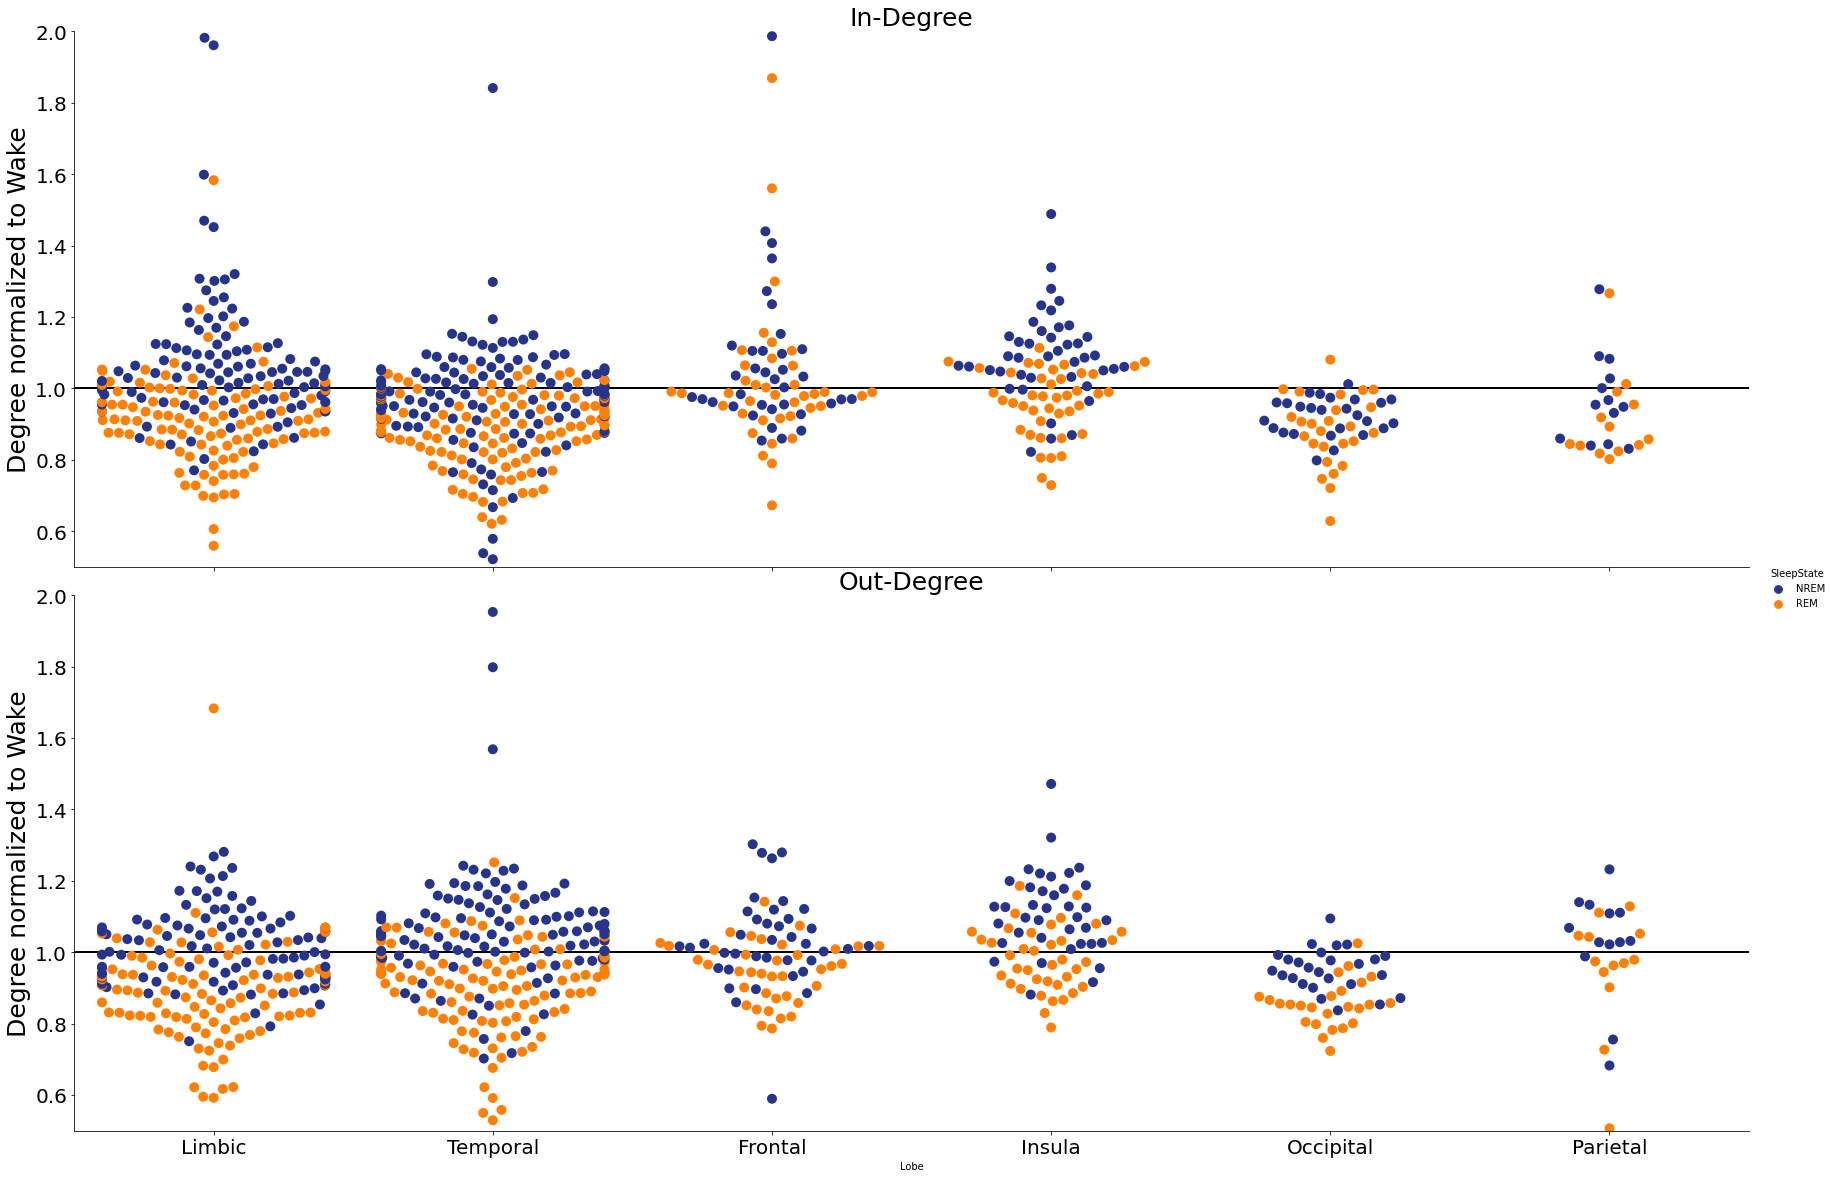

In [84]:
g = sns.catplot(x ='Lobe', y='LLs_n', hue='SleepState', data= G_deg[(G_deg.Lobe != 'Central')&(G_deg.Lobe != 'Unknown')&(G_deg.Lobe != 'out')&(G_deg.SleepState != 'Wake')], row = 'Deg', kind='swarm',height=8,aspect= 3, s=10, palette=['#27348B','#FF8007'])
ax = g.axes  # access a grid of 'axes' objects
plt.ylim([0.5,2])
ax[0,0].axhline(1, color='k', linewidth=2)
ax[1,0].axhline(1, color='k', linewidth=2)
plt.xticks(fontsize=20)
ax[1,0].tick_params(labelsize=20)
ax[0,0].tick_params(labelsize=20)
ax[0,0].set_title('In-Degree', fontsize=25)
ax[1,0].set_title('Out-Degree', fontsize=25)
ax[0,0].set_ylabel('Degree normalized to Wake', fontsize=25)
ax[1,0].set_ylabel('Degree normalized to Wake', fontsize=25)
plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\Sleep\degree\\Deg_Lobe2.svg')

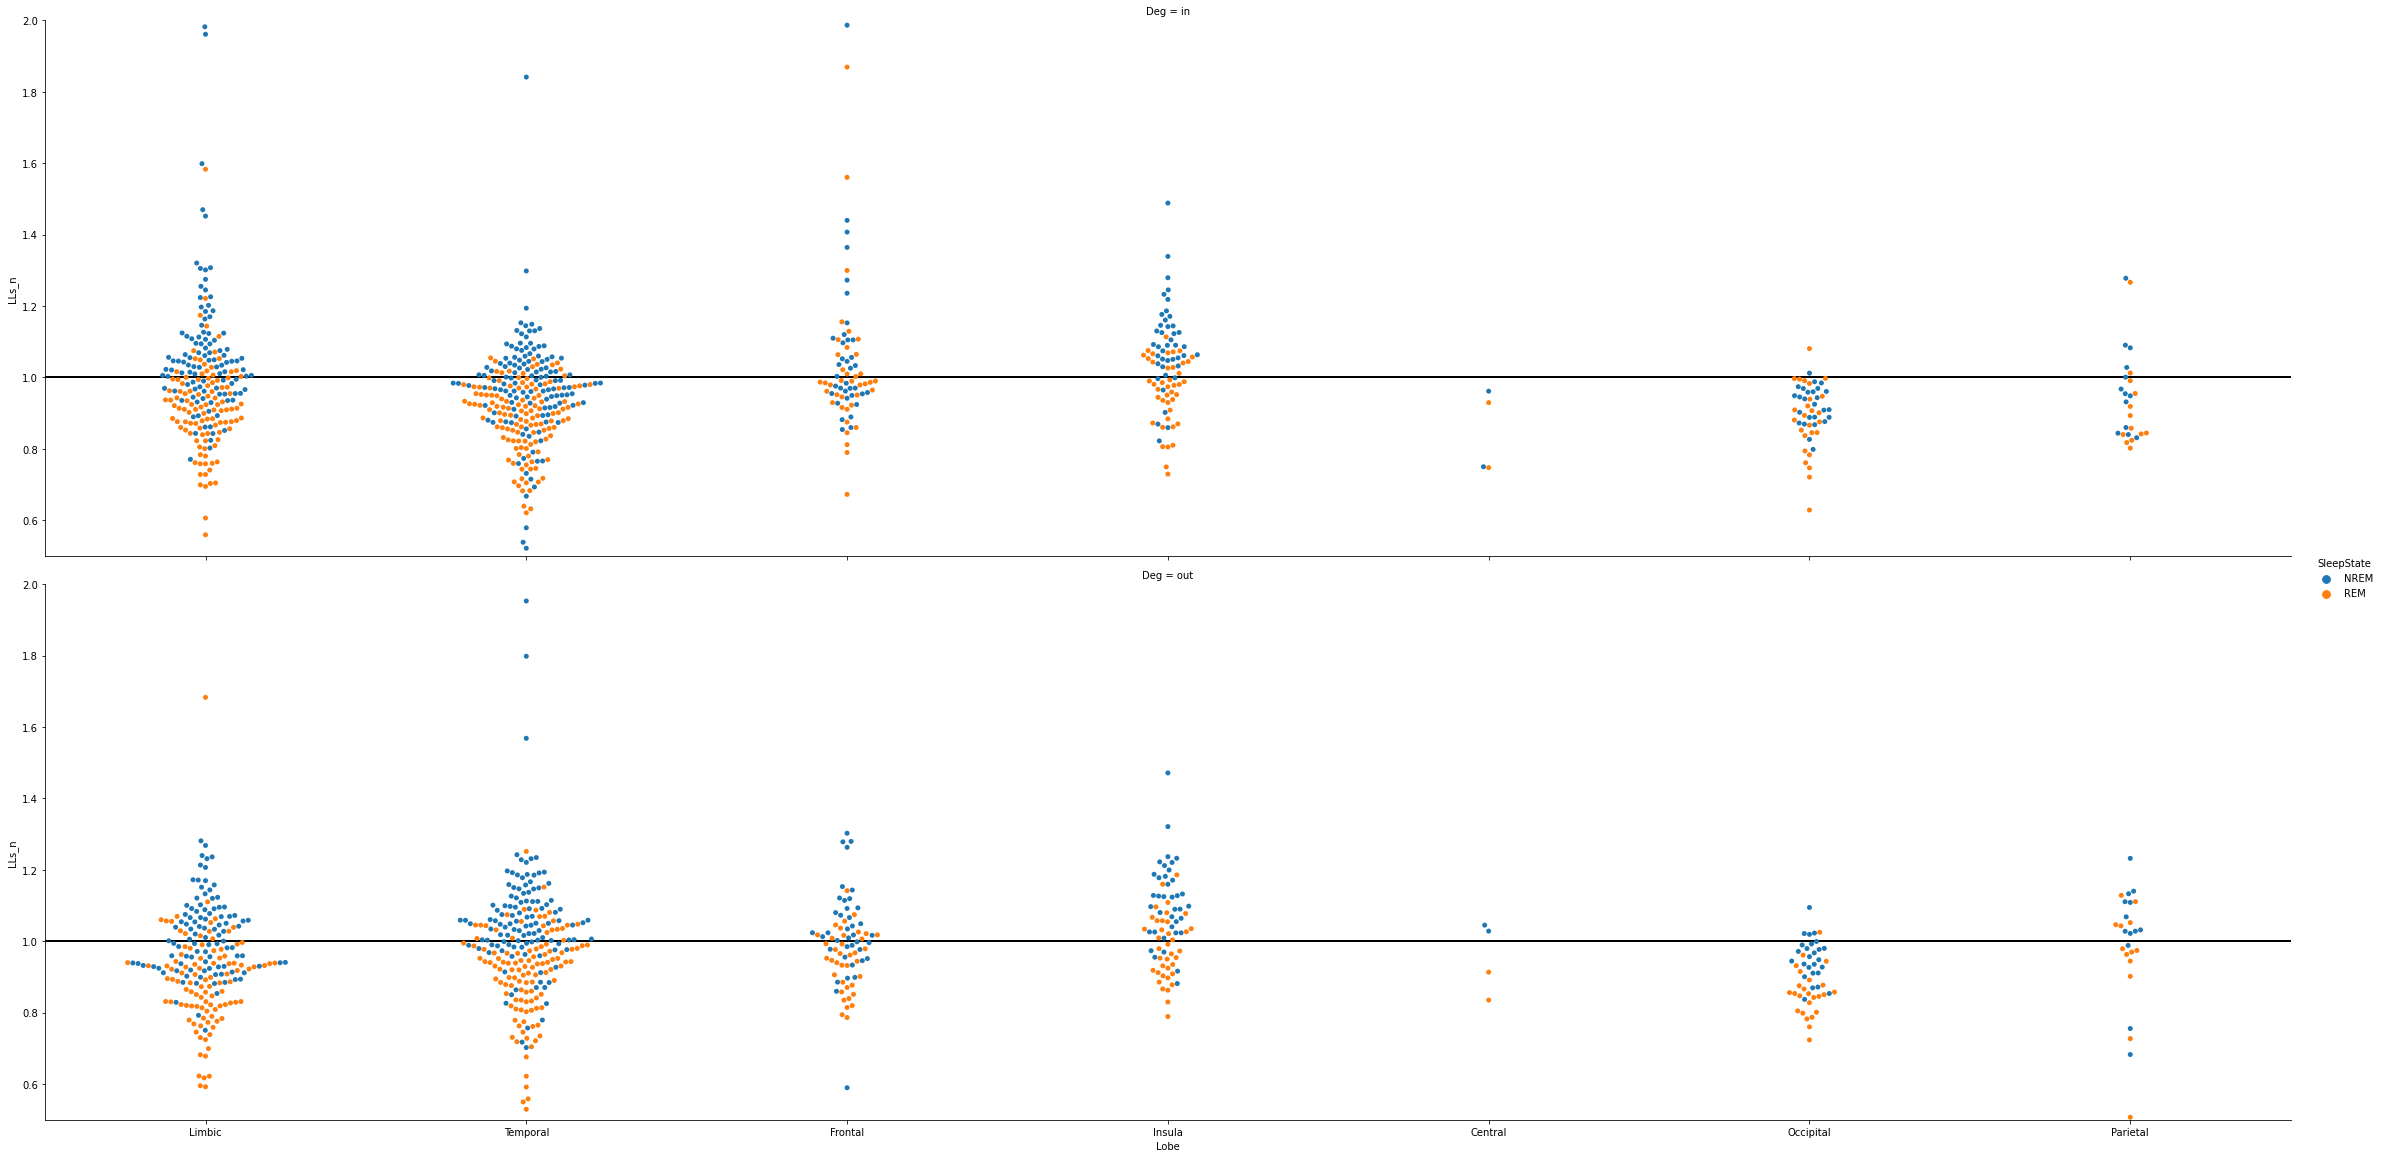

In [18]:
g = sns.catplot(x ='Lobe', y='LLs_n', hue='SleepState', data= G_deg[(G_deg.Lobe != 'Unknown')&(G_deg.Lobe != 'out')&(G_deg.SleepState != 'Wake')], row = 'Deg', kind='swarm',s=5,height=8,aspect= 4)
ax = g.axes  # access a grid of 'axes' objects
plt.ylim([0.5,2])
ax[0,0].axhline(1, color='k', linewidth=2)
ax[1,0].axhline(1, color='k', linewidth=2)
plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\Sleep\degree\\Deg_Lobe.svg')

In [48]:
data_con_file = 'Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\Sleep\degree\\data_con.csv'
if os.path.exists(data_con_file)*0:
    data_deg = pd.read_csv(data_con_file)
else:
    for i in range(len(subjs)):
        print('loading -- ' + subjs[i], end='\r')
        subj = subjs[i]
        path_gen = os.path.join('y:\\eLab\Patients\\' + subj)
        if not os.path.exists(path_gen):
            path_gen = 'T:\\EL_experiment\\Patients\\' + subj
        path_patient = path_gen + '\Data\EL_experiment'
        path_infos = os.path.join(path_patient, 'infos')
        if not os.path.exists(path_infos):
            path_infos = path_gen + '\\infos'
        path_patient_analysis = 'y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj

        file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
        con_trial = pd.read_csv(file_con)

        lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
        labels_all = lbls.label.values
        labels_clinic = lbls.Clinic.values
        labels_region = lbls.Region.values
        labels_region[labels_region == 'HIPP'] = 'Mesiotemporal'
        labels_region[labels_region == 'HIPP '] = 'Mesiotemporal'
        labels_region[labels_region == 'ENT'] = 'Basotemporal'
        bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

        # data_A = data_A[~np.isin(data_A.Chan,bad_all)&~np.isin(data_A.Stim,bad_all)]
        
        con_trial = con_trial[con_trial.Sig>=0]
        con_trial.loc[con_trial.SleepState=='W','SleepState'] = 'Wake'
        con_trial.insert(3,'LLs', con_trial.LL*con_trial.Sig)
        con_trial.insert(3,'LLz', con_trial.LL*con_trial.Sig)
        con_trial['LLz'] = con_trial.groupby(['Stim','Chan'])['LLs'].transform(lambda x: (x / x.max()))
        # mean CCEP magnitude for each conenction at each sleep state
        G = con_trial.groupby(['Stim','Chan','SleepState'], as_index=False)[['Sig','LLz','LLs', 'd']].mean()
        metrics = ['Sig','LLz','LLs']
        # degrees: sum up all CCEP magnitudes with specific channel being reponse or stimulation channel
        G_in = G.groupby(['Chan','SleepState'], as_index=False)[metrics].sum()
        G_in.insert(3,'Deg', 'in')
        G_out = G.groupby(['Stim','SleepState'], as_index=False)[metrics].sum()
        G_out.insert(3,'Deg', 'out')
        G_out.insert(0,'Chan', G_out.Stim)
        G_deg = pd.concat([G_in,G_out])
        G_deg = G_deg.reset_index(drop=True)
        G_deg = G_deg.drop(columns=['Stim'])
        
        for m in metrics:
            means_stds = G_deg.groupby(['Chan','Deg','SleepState'])[m].agg(['mean','std']).reset_index()
            means_stds = means_stds[means_stds.SleepState=='Wake']
            means_stds = means_stds.drop(columns=['SleepState'])
            G_deg = G_deg.merge(means_stds,on=['Chan','Deg'])
            G_deg[m+'_n'] = (G_deg[m] / G_deg['mean']) 
            G_deg = G_deg.drop(columns=['mean', 'std'])
        
        G_deg.insert(0,'Area','Test')
        for c in np.unique(G_deg.Chan.values.astype('int')):
            G_deg.loc[G_deg.Chan==c,'Area']= labels_region[c]
        G_deg.insert(0,'Subj', subj)
        if i == 0:
            data_deg = G_deg
        else:
            data_deg = pd.concat([data_deg, G_deg])
            data_deg = data_deg.reset_index(drop=True)
        
    data_deg.to_csv(data_con_file,
        header=True, index=False)

In [134]:
deg_summary.insert(3,'thr_high',thr[:,1])
deg_summary.insert(3,'thr_low',thr[:,0])

In [118]:
deg_summary = data_deg[(data_deg.Lobe != 'Unknown')&(data_deg.Lobe != 'out')&(data_deg.SleepState != 'Wake')]
deg_summary = deg_summary.reset_index(drop=True)
deg_summary = deg_summary.groupby(['Lobe', 'SleepState'], as_index=False)['LLs_n'].mean()
deg_summary.insert(deg_summary.shape[1], str(n+1), deg_summary.LLs_n)
deg_summary = deg_summary.drop(columns='LLs_n')

In [105]:
deg_summary.insert(deg_summary.shape[1], str(n+1), deg_summary.LLs_n)

In [107]:
deg_summary = deg_summary.drop(columns='LLs_n')

In [98]:
deg_summary = data_deg[(data_deg.Lobe != 'Unknown')&(data_deg.Lobe != 'out')&(data_deg.SleepState != 'Wake')]
deg_summary = deg_summary.reset_index(drop=True)
deg_summary = deg_summary.groupby(['Lobe', 'SleepState'], as_index=False)['LLs_n'].mean()

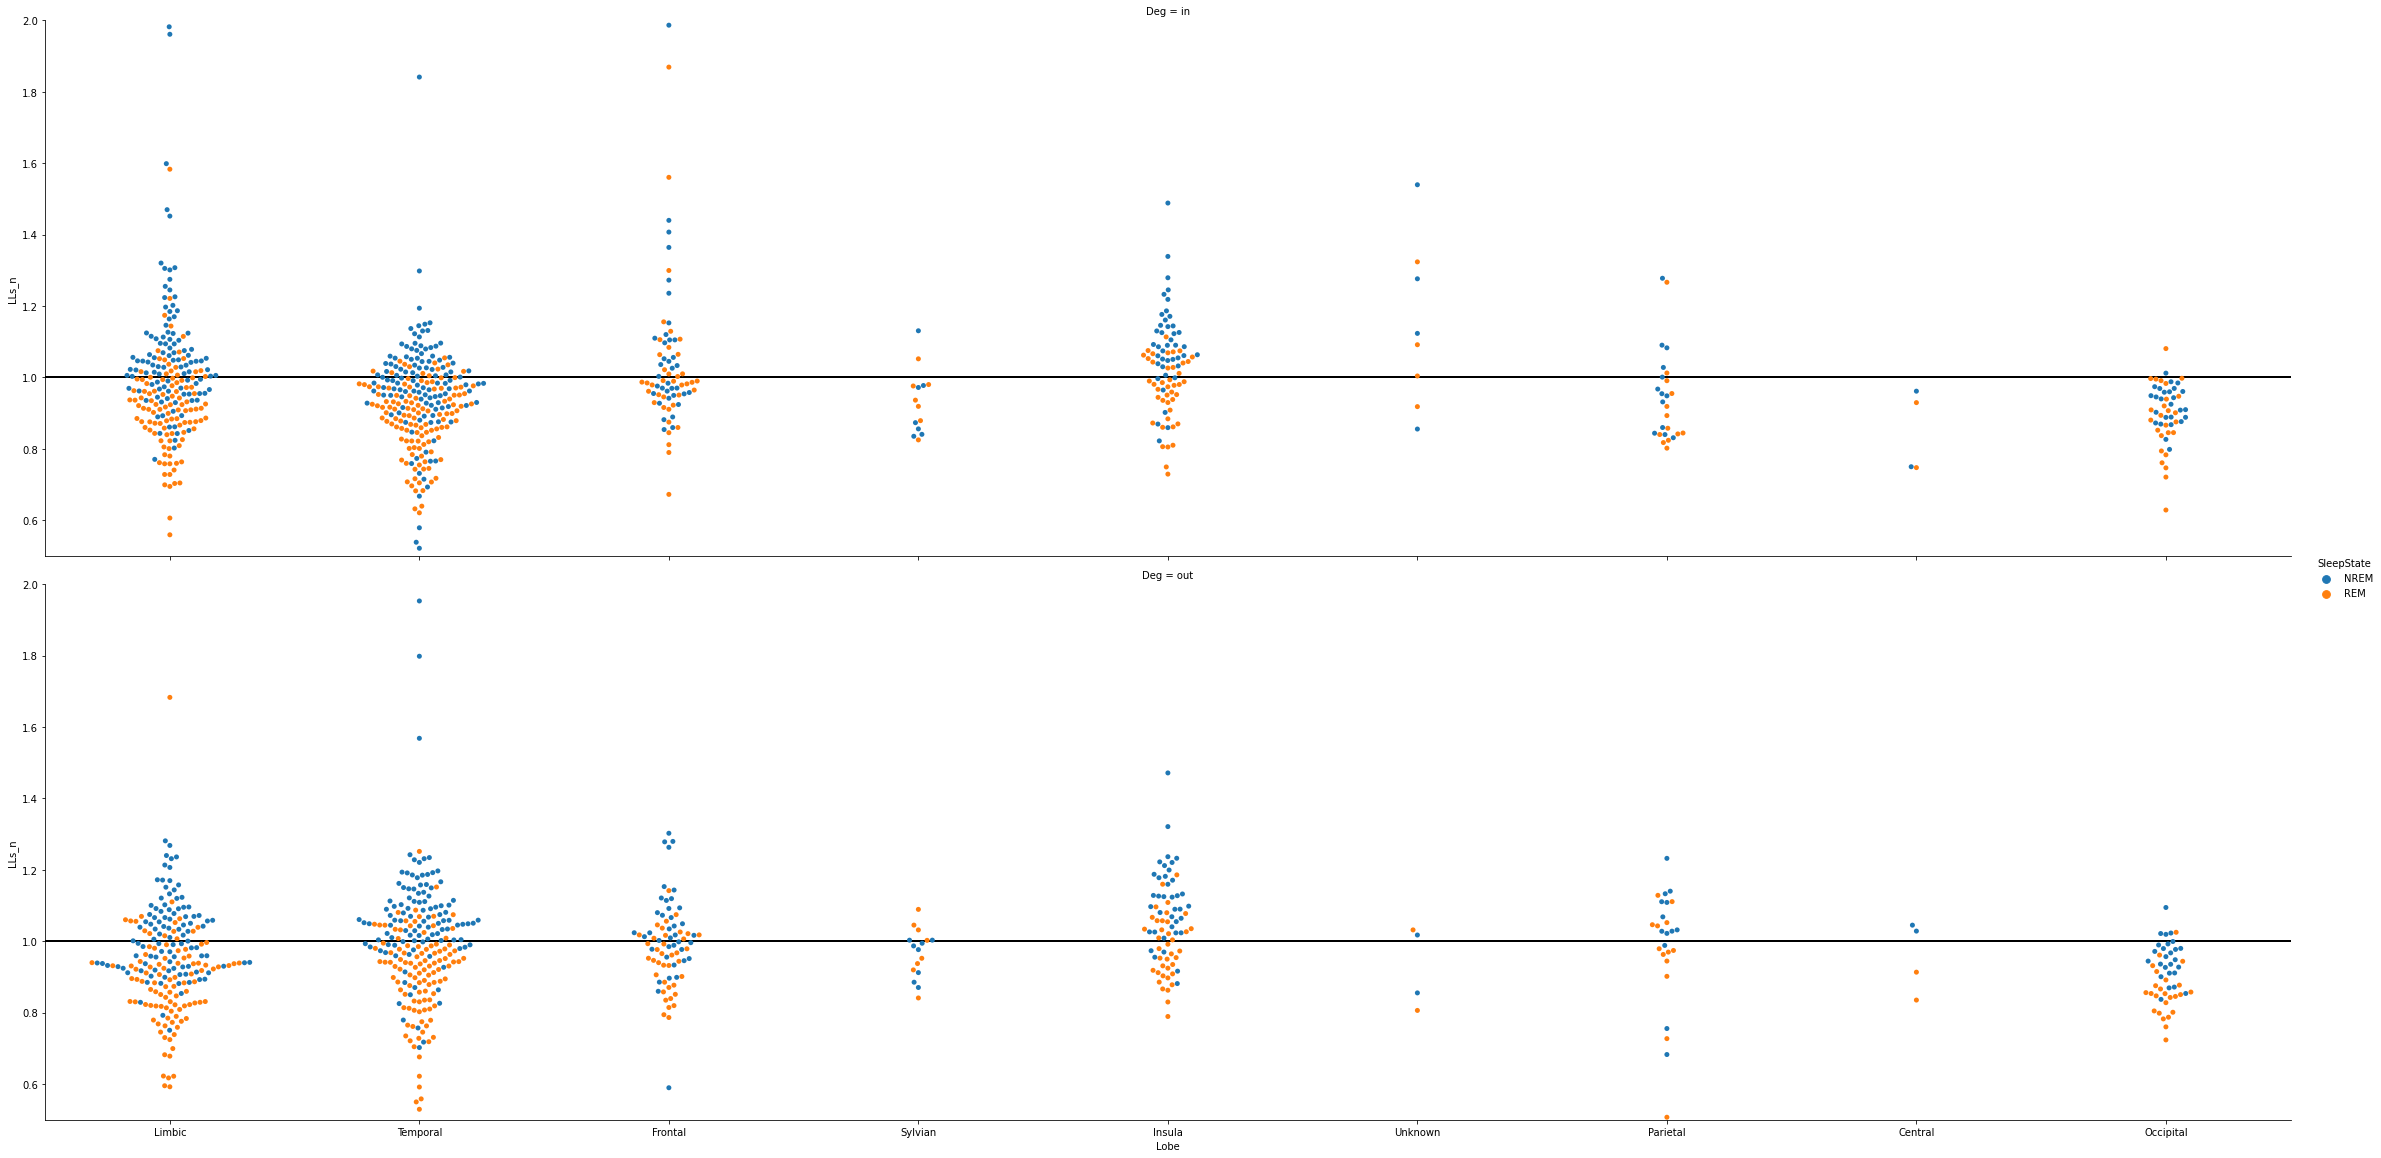

In [89]:
g = sns.catplot(x ='Lobe', y='LLs_n', hue='SleepState', data= data_deg[(data_deg.Lobe != 'out')&(data_deg.SleepState != 'Wake')], row = 'Deg', kind='swarm',s=5,height=8,aspect= 4)
ax = g.axes  # access a grid of 'axes' objects
plt.ylim([0.5,2])
ax[0,0].axhline(1, color='k', linewidth=2)
ax[1,0].axhline(1, color='k', linewidth=2)

In [86]:
# data_deg.insert(1, 'Lobe', data_con.StimR)
for region in np.unique(data_deg[['Area']]):
    if len(regions.Lobe[regions.label==region].values)>0:
        lobe = regions.Lobe[regions.label==region].values[0]
    else:
        lobe = 'out'
    data_deg.loc[data_deg.Area==region, 'Lobe'] = lobe

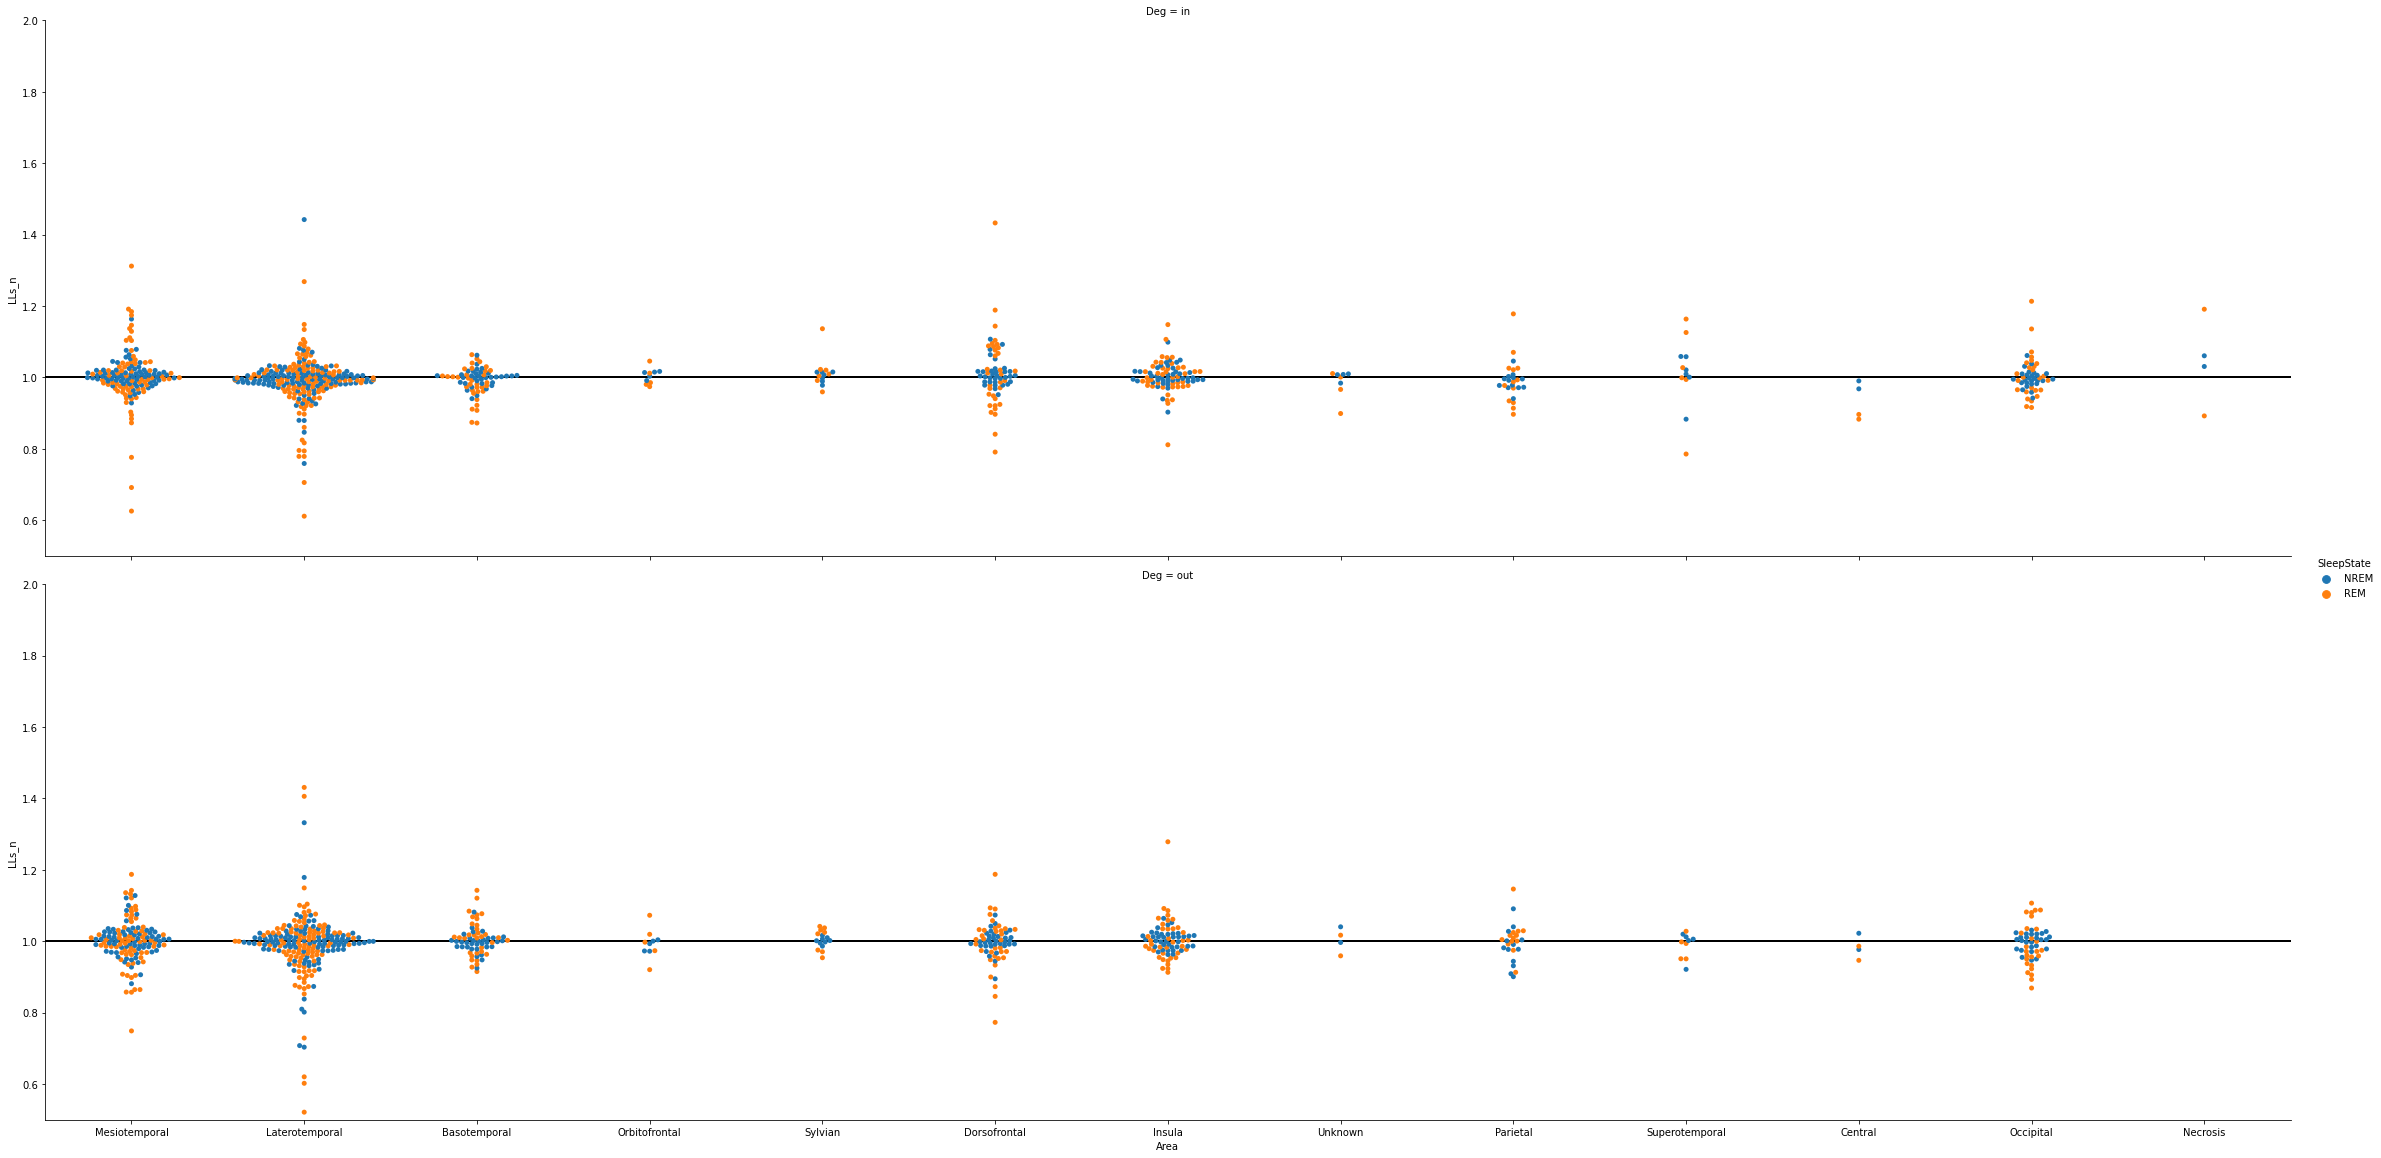

In [77]:
g = sns.catplot(x ='Area', y='LLs_n', hue='SleepState', data= data_deg_surr[data_deg_surr.SleepState != 'Wake'], row = 'Deg', kind='swarm',s=5,height=8,aspect= 4)
ax = g.axes  # access a grid of 'axes' objects
plt.ylim([0.5,2])
ax[0,0].axhline(1, color='k', linewidth=2)
ax[1,0].axhline(1, color='k', linewidth=2)

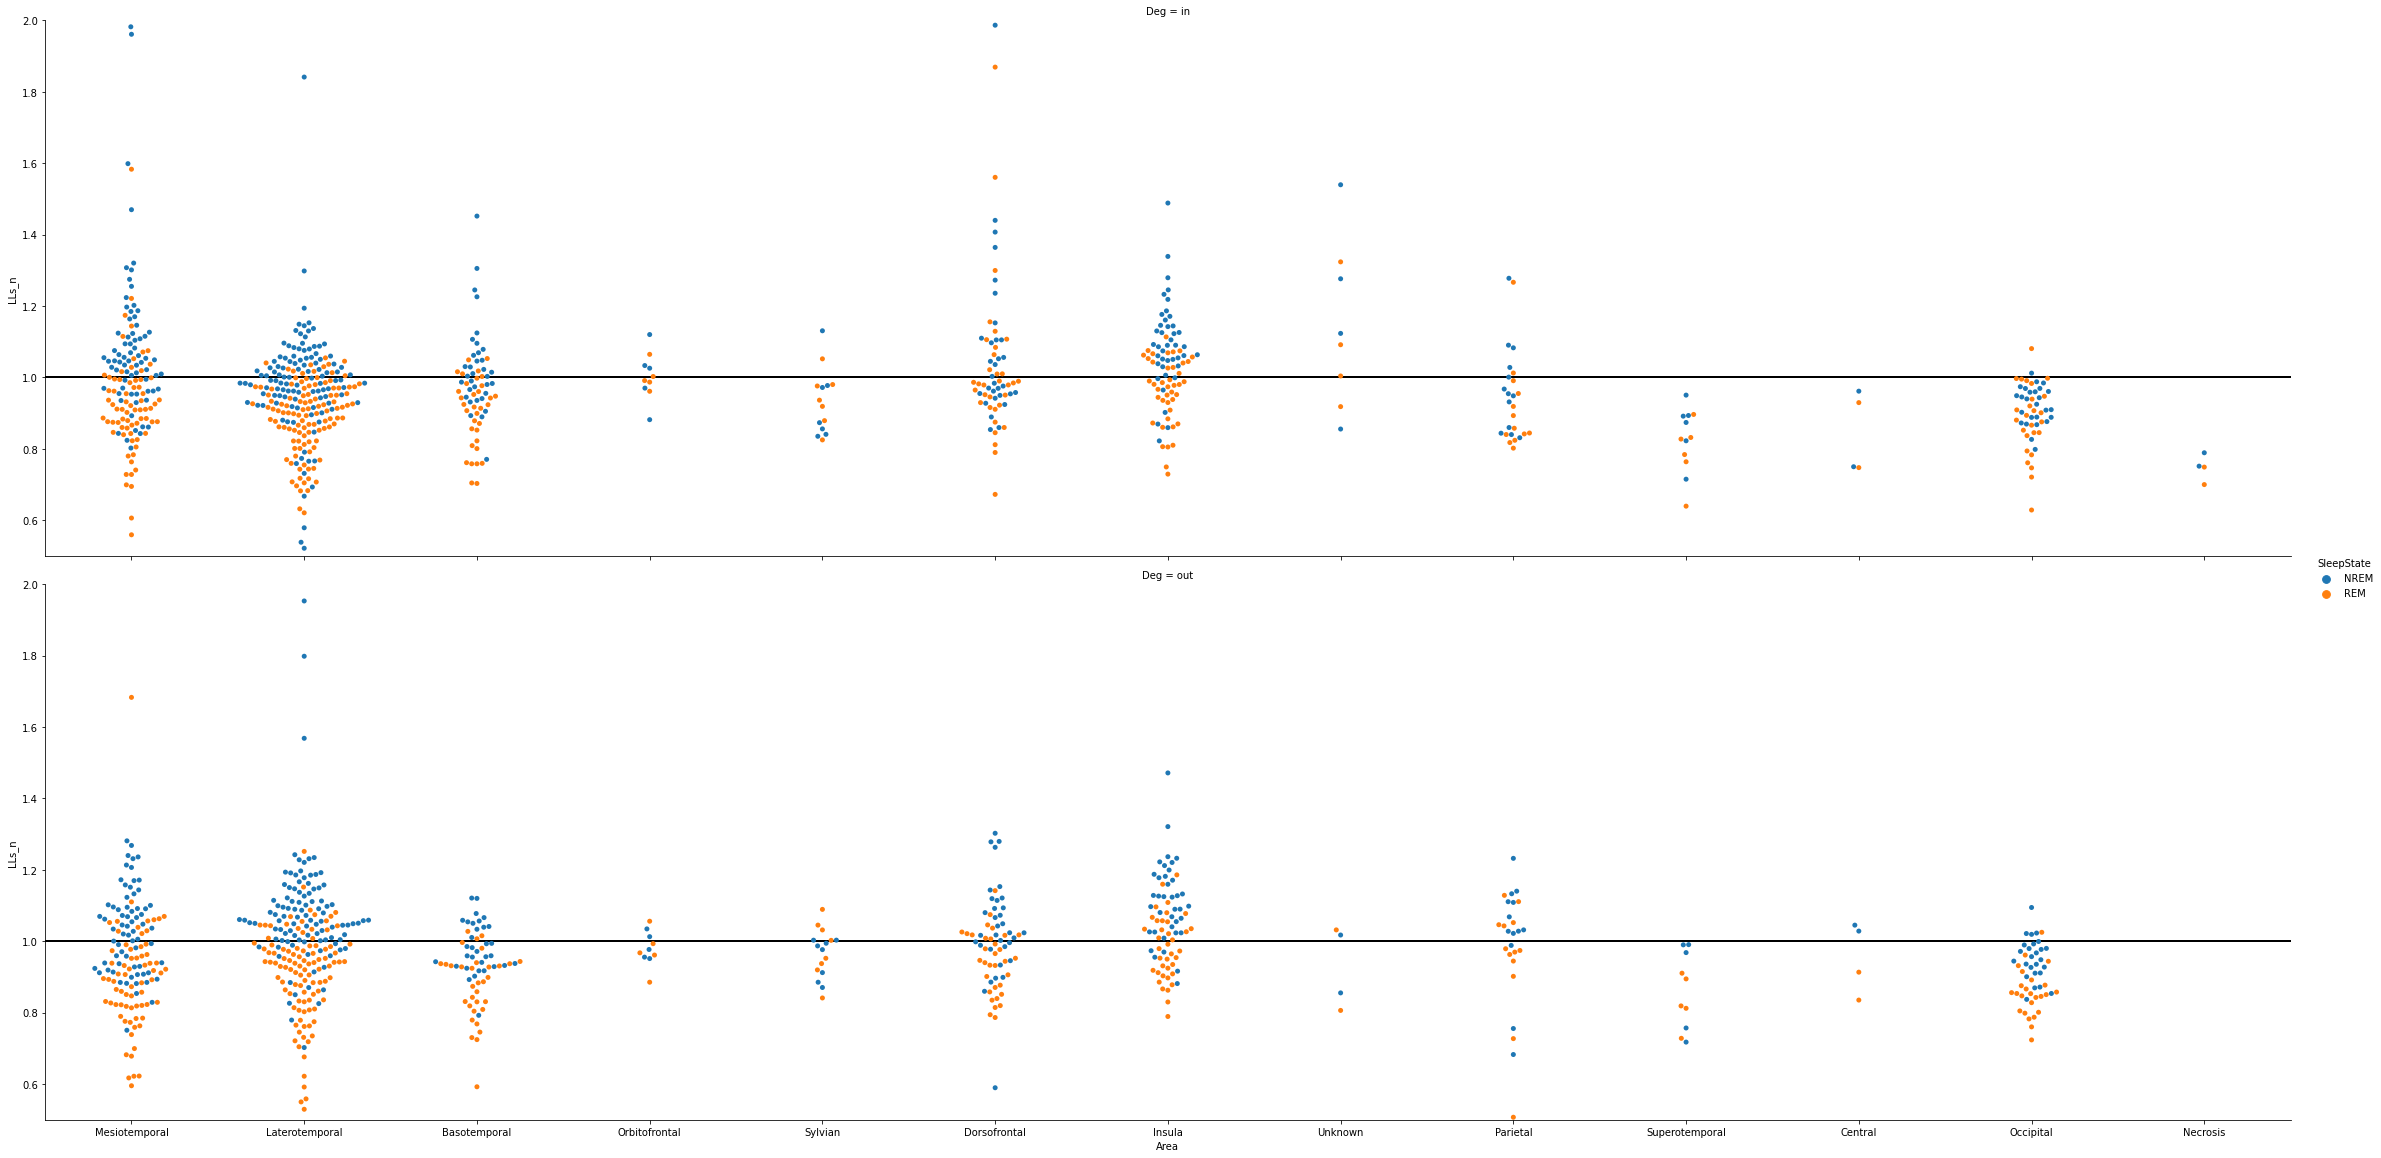

In [78]:
g = sns.catplot(x ='Area', y='LLs_n', hue='SleepState', data= data_deg[data_deg.SleepState != 'Wake'], row = 'Deg', kind='swarm',s=5,height=8,aspect= 4)
ax = g.axes  # access a grid of 'axes' objects
plt.ylim([0.5,2])
ax[0,0].axhline(1, color='k', linewidth=2)
ax[1,0].axhline(1, color='k', linewidth=2)

## Connection-wise

In [20]:
data_con_file = 'Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\Sleep\connectogram\\data_con_stat.csv'
if os.path.exists(data_con_file):
    data_con = pd.read_csv(data_con_file)
else:
    chan_n_max = 0
    for i in range(len(subjs)):
        print('loading -- ' + subjs[i], end='\r')
        subj = subjs[i]
        path_gen = os.path.join('y:\\eLab\Patients\\' + subj)
        if not os.path.exists(path_gen):
            path_gen = 'T:\\EL_experiment\\Patients\\' + subj
        path_patient = path_gen + '\Data\EL_experiment'
        path_infos = os.path.join(path_patient, 'infos')
        if not os.path.exists(path_infos):
            path_infos = path_gen + '\\infos'
        path_patient_analysis = 'y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj

        file_con_sleep = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\con_sleep_stats.csv'
        # , con_sleep_stats, con_sleep
        if os.path.exists(file_con_sleep):
            data_A = pd.read_csv(file_con_sleep)

            lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
            labels_all = lbls.label.values
            labels_clinic = lbls.Clinic.values
            labels_region = lbls.Region.values
            labels_region[labels_region == 'HIPP'] = 'Mesiotemporal'
            labels_region[labels_region == 'HIPP '] = 'Mesiotemporal'
            labels_region[labels_region == 'ENT'] = 'Basotemporal'
            bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

            StimChanIx = np.unique(data_A.Stim)
            bad_chans = pd.read_csv(path_patient_analysis + '/BrainMapping/data/badchan.csv')
            bad_chans = np.unique(np.array(np.where(bad_chans.values[:, 1:] == 1))[0, :])
            non_stim = np.arange(len(labels_all))
            non_stim = np.delete(non_stim, StimChanIx.astype('int'), 0)
            WM_chans = np.where(labels_region == 'WM')[0]
            bad_all = np.unique(np.concatenate([WM_chans, bad_region, bad_chans, non_stim])).astype('int')

            # data_A = data_A[~np.isin(data_A.Chan,bad_all)&~np.isin(data_A.Stim,bad_all)]
            data_A.reset_index(drop=True)
            data_A.insert(0, 'Subj', subjs[i])
            data_A.insert(1, 'StimR', '0')
            data_A.insert(2, 'ChanR', '0')
            data_A.insert(1, 'StimA', '0')
            data_A.insert(2, 'ChanA', '0')
            data_A.insert(8, 'H', 0)
            for c in np.unique(data_A[['Chan', 'Stim']]).astype('int'):
                data_A.loc[data_A.Chan == c, 'ChanR'] = labels_region[c]
                data_A.loc[data_A.Stim == c, 'StimR'] = labels_region[c]
                data_A.loc[data_A.Chan == c, 'ChanA'] = " ".join(re.findall("[a-zA-Z_]+", labels_all[c]))
                data_A.loc[data_A.Stim == c, 'StimA'] = " ".join(re.findall("[a-zA-Z_]+", labels_all[c]))
                chans = data_A.loc[data_A.Stim == c, 'Chan'].values.astype('int')
                data_A.loc[data_A.Stim == c, 'H'] = np.array(lbls.Hemisphere[chans] != lbls.Hemisphere[c]) * 1
            #data_A = data_A[~np.isnan(data_A.N1.values)]
            data_A.Stim = data_A.Stim + chan_n_max + 1
            data_A.Chan = data_A.Chan + chan_n_max + 1

            if chan_n_max == 0:
                data_con = data_A
            else:
                data_con = pd.concat([data_con, data_A])
                data_con = data_con.reset_index(drop=True)
            chan_n_max = np.max(data_con[['Chan', 'Stim']].values)
    data_con = data_con[(data_con.ChanA != 'Necrosis') & (data_con.StimA != 'Necrosis')]

    data_con.to_csv(data_con_file,
        header=True, index=False)

In [21]:
data_con.insert(0, 'ChanL', data_con.StimR)
data_con.insert(0, 'StimL', data_con.StimR)
for region in np.unique(data_con[['StimR', 'ChanR']]):
    lobe = regions.Lobe[regions.label==region].values[0]
    data_con.loc[data_con.StimR==region, 'StimL'] = lobe
    data_con.loc[data_con.ChanR==region, 'ChanL'] = lobe

StimL     ChanL   Subj StimA ChanA          StimR           ChanR  \
0       Limbic    Limbic  EL019   Amy   Amy  Mesiotemporal   Mesiotemporal   
1       Limbic    Limbic  EL019   Amy   Amy  Mesiotemporal   Mesiotemporal   
2       Limbic    Limbic  EL019   Amy   Amy  Mesiotemporal   Mesiotemporal   
3       Limbic  Temporal  EL019   Amy   STG  Mesiotemporal  Laterotemporal   
4       Limbic  Temporal  EL019   Amy   STG  Mesiotemporal  Laterotemporal   
...        ...       ...    ...   ...   ...            ...             ...   
50328  Frontal   Frontal  EL017   SFS   IFS   Dorsofrontal    Dorsofrontal   
50329  Frontal   Frontal  EL017   SFS   IFS   Dorsofrontal    Dorsofrontal   
50330  Frontal   Frontal  EL017   SFS   SFS   Dorsofrontal    Dorsofrontal   
50331  Frontal   Frontal  EL017   SFS   SFS   Dorsofrontal    Dorsofrontal   
50332  Frontal   Frontal  EL017   SFS   SFS   Dorsofrontal    Dorsofrontal   

        Stim   Chan SleepState  H      Prob         LL            Dist  \
0        1.0    3.0       NREM  0  1.000000  11.659413  local (<15 mm)   
1        1.0    3.0        REM  0  1.000000  12.268156  local (<15 mm)   
2        1.0    3.0       Wake  0  0.987730   9.446486  local (<15 mm)   
3        1.0    8.0       NREM  0  0.621622   3.636706   short (<30mm)   
4        1.0    8.0        REM  0  0.800000   3.409969   short (<30mm)   
...      ...    ...        ... ..       ...        ...             ...   
50328  484.0  480.0        REM  0  1.000000   3.549227  local (<15 mm)   
50329  484.0  480.0       Wake  0  1.000000   4.296032  local (<15 mm)   
50330  484.0  482.0       NREM  0  1.000000   9.588881  local (<15 mm)   
50331  484.0  482.0        REM  0  1.000000   6.717892  local (<15 mm)   
50332  484.0  482.0       Wake  0  1.000000   7.940379  local (<15 mm)   

          LL_cd   P_ratio LL_cd_sig P_ratio_sig     d  
0      1.190153  1.012422      True       False   7.0  
1      1.512825  1.012422      True       False   7.0  
2      0.000000  1.000000       NaN         NaN   7.0  
3      0.060039  1.378562     False        True  24.5  
4     -0.150910  1.774150     False       False  24.5  
...         ...       ...       ...         ...   ...  
50328 -0.685965  1.000000     False       False  14.0  
50329  0.000000  1.000000       NaN         NaN  14.0  
50330  1.499568  1.000000      True       False   7.0  
50331 -1.338927  1.000000      True       False   7.0  
50332  0.000000  1.000000       NaN         NaN   7.0  

[50057 rows x 19 columns]

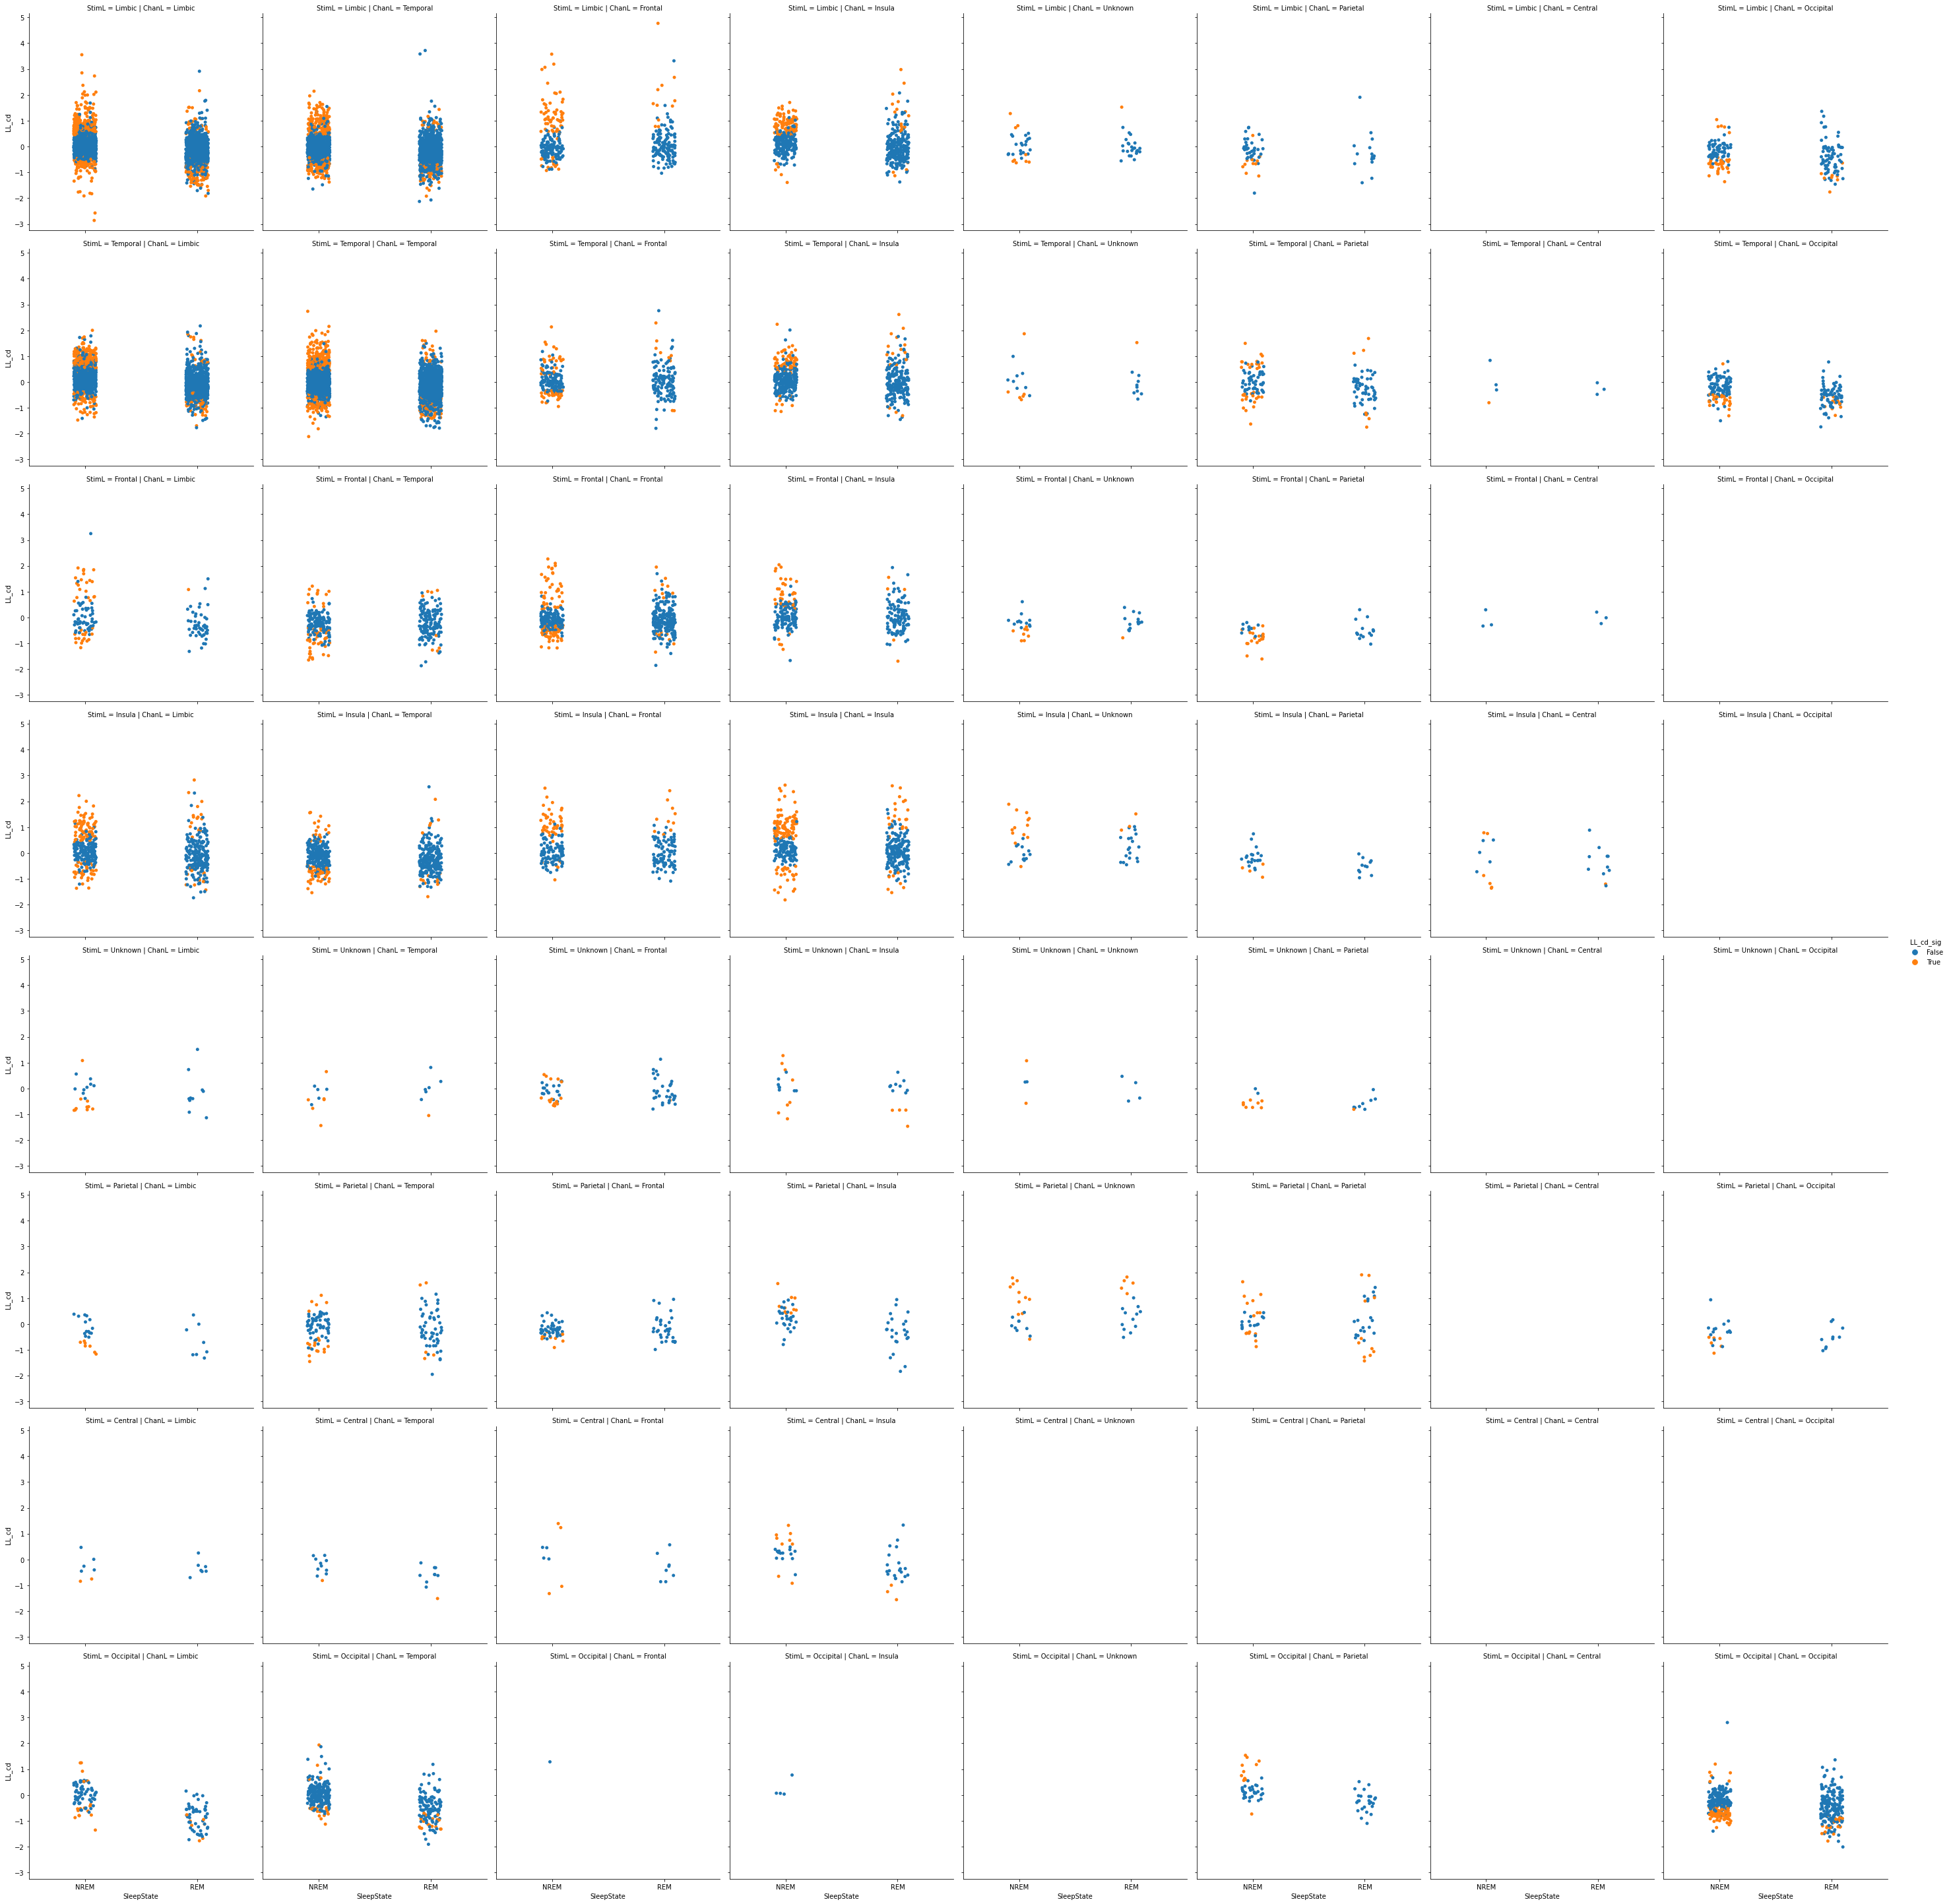

In [23]:
sns.catplot(x='SleepState', y= 'LL_cd', hue='LL_cd_sig',data=data_con[data_con.SleepState!='Wake'], row='StimL', col = 'ChanL')

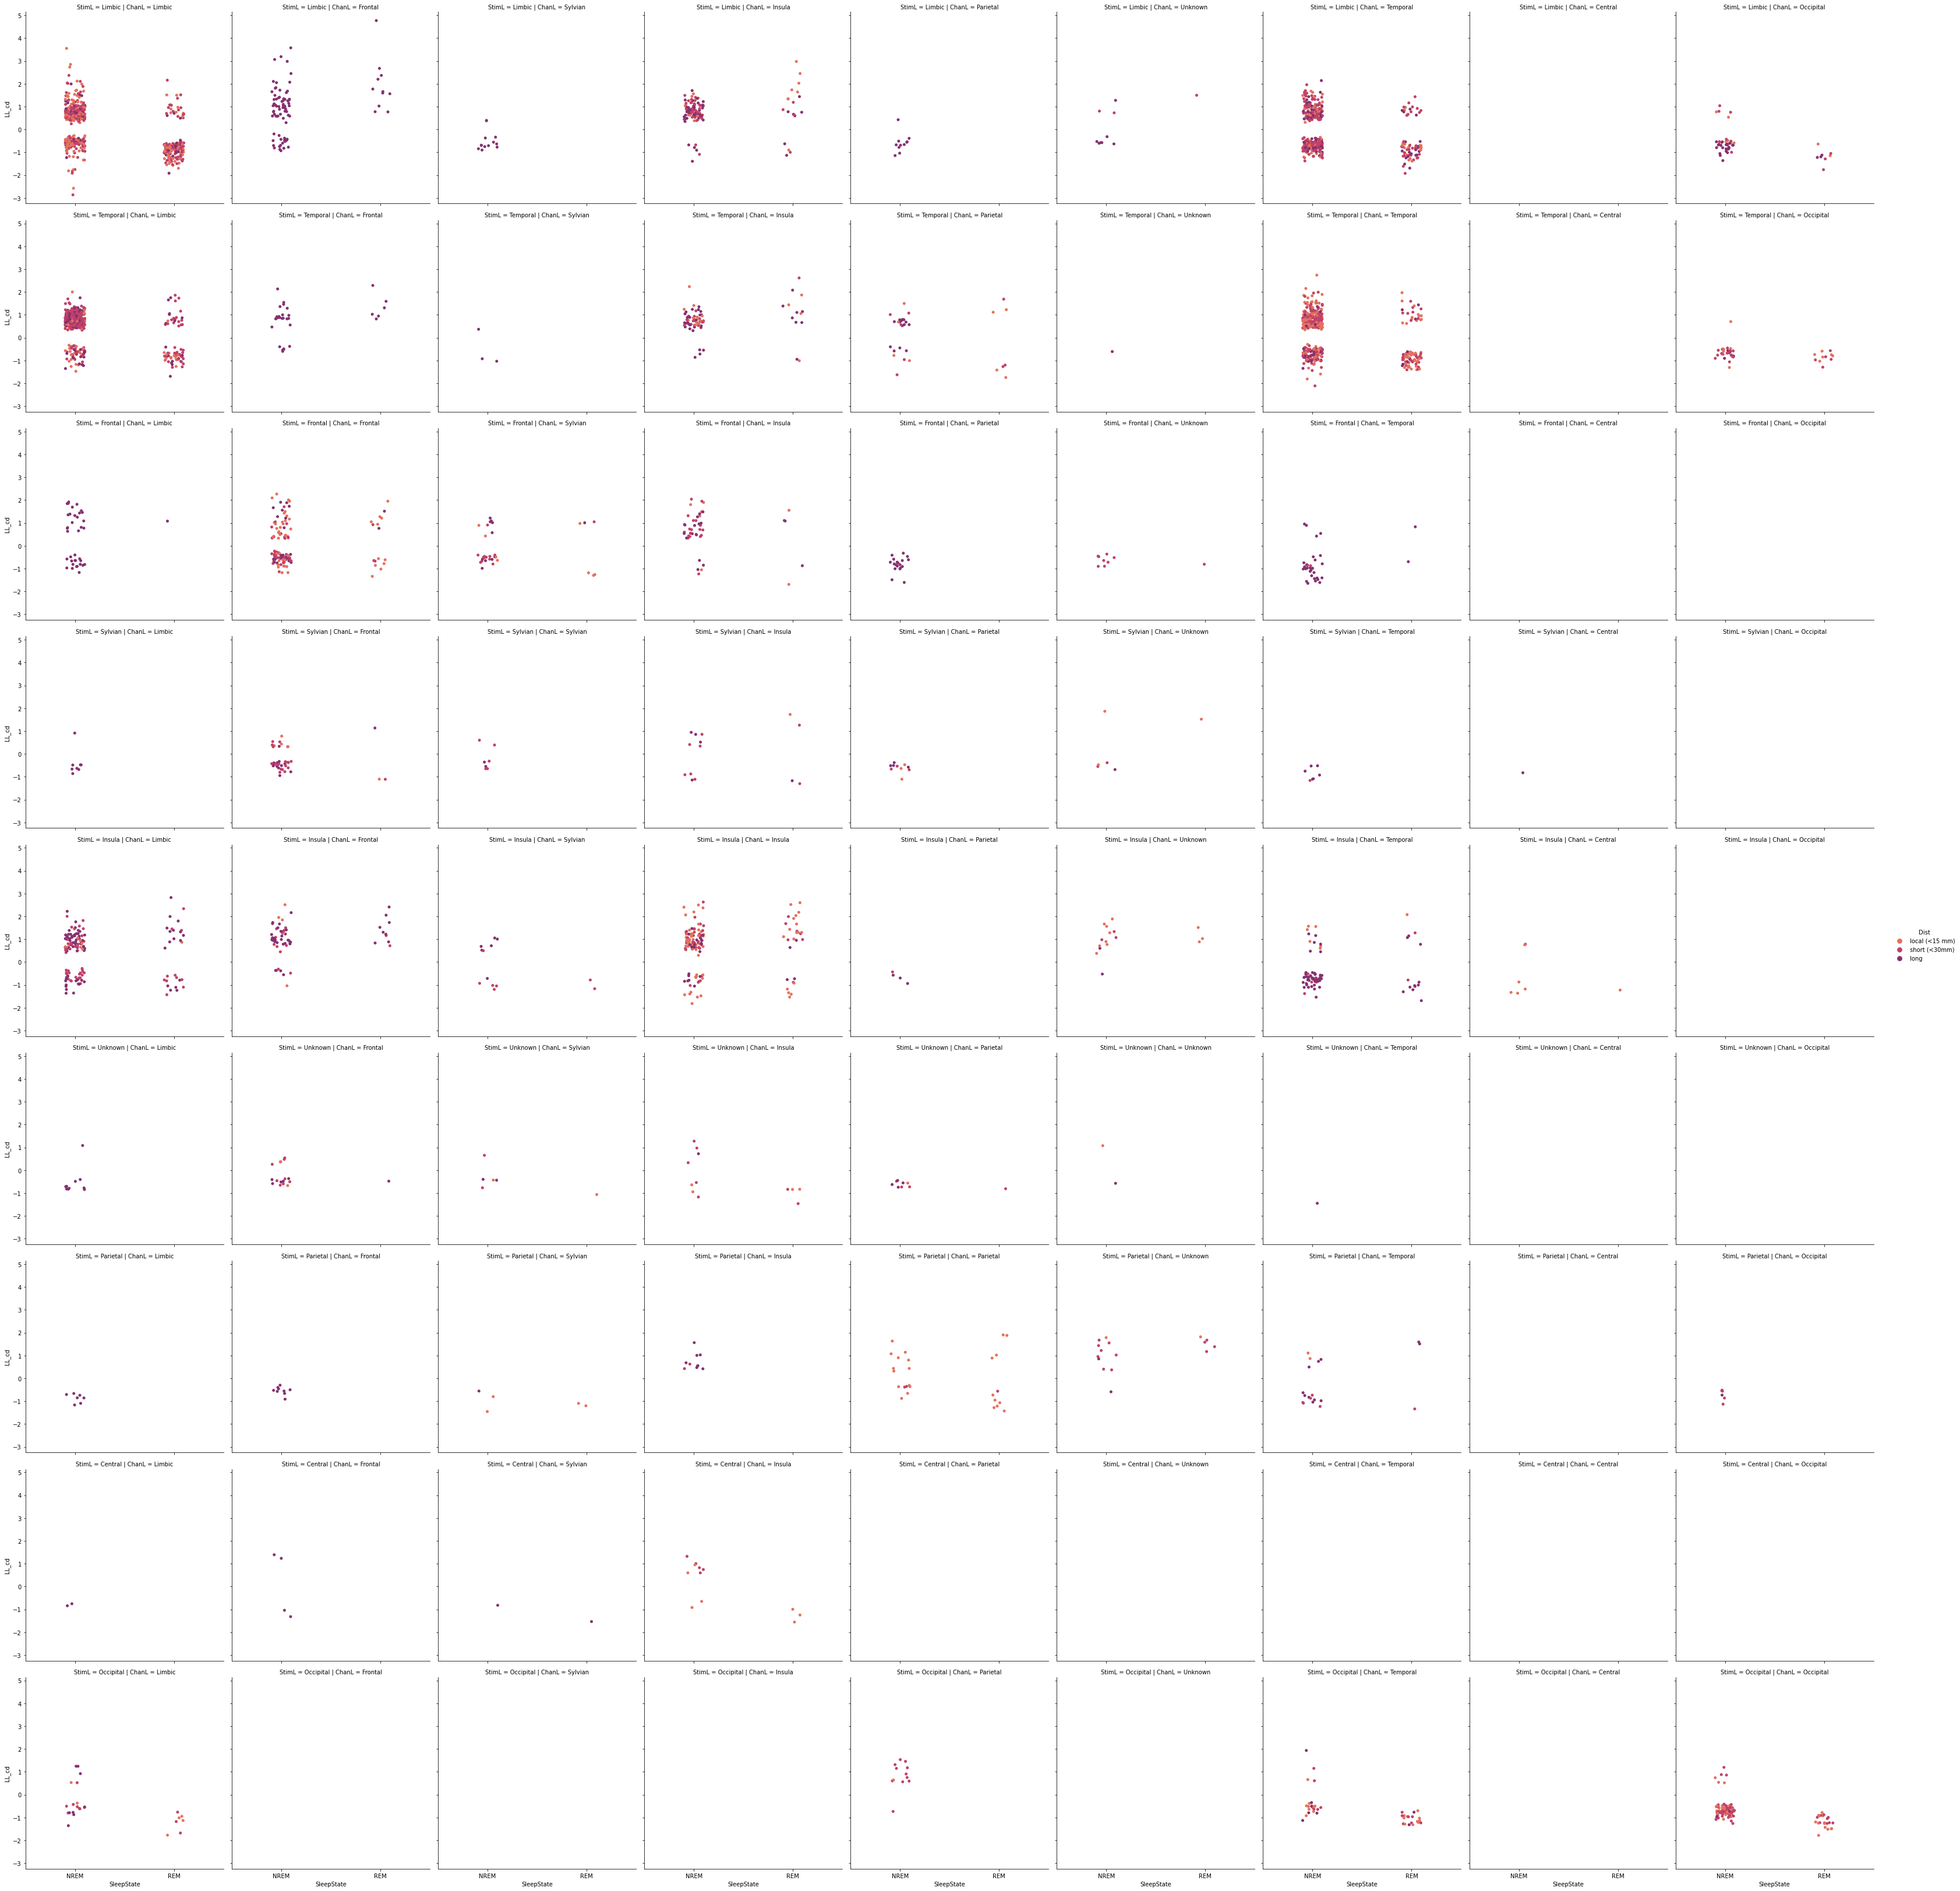

In [40]:
sns.catplot(x='SleepState', y= 'LL_cd', hue='Dist',data=data_con[data_con.LL_cd_sig==1], row='StimL', col = 'ChanL', palette = "flare")

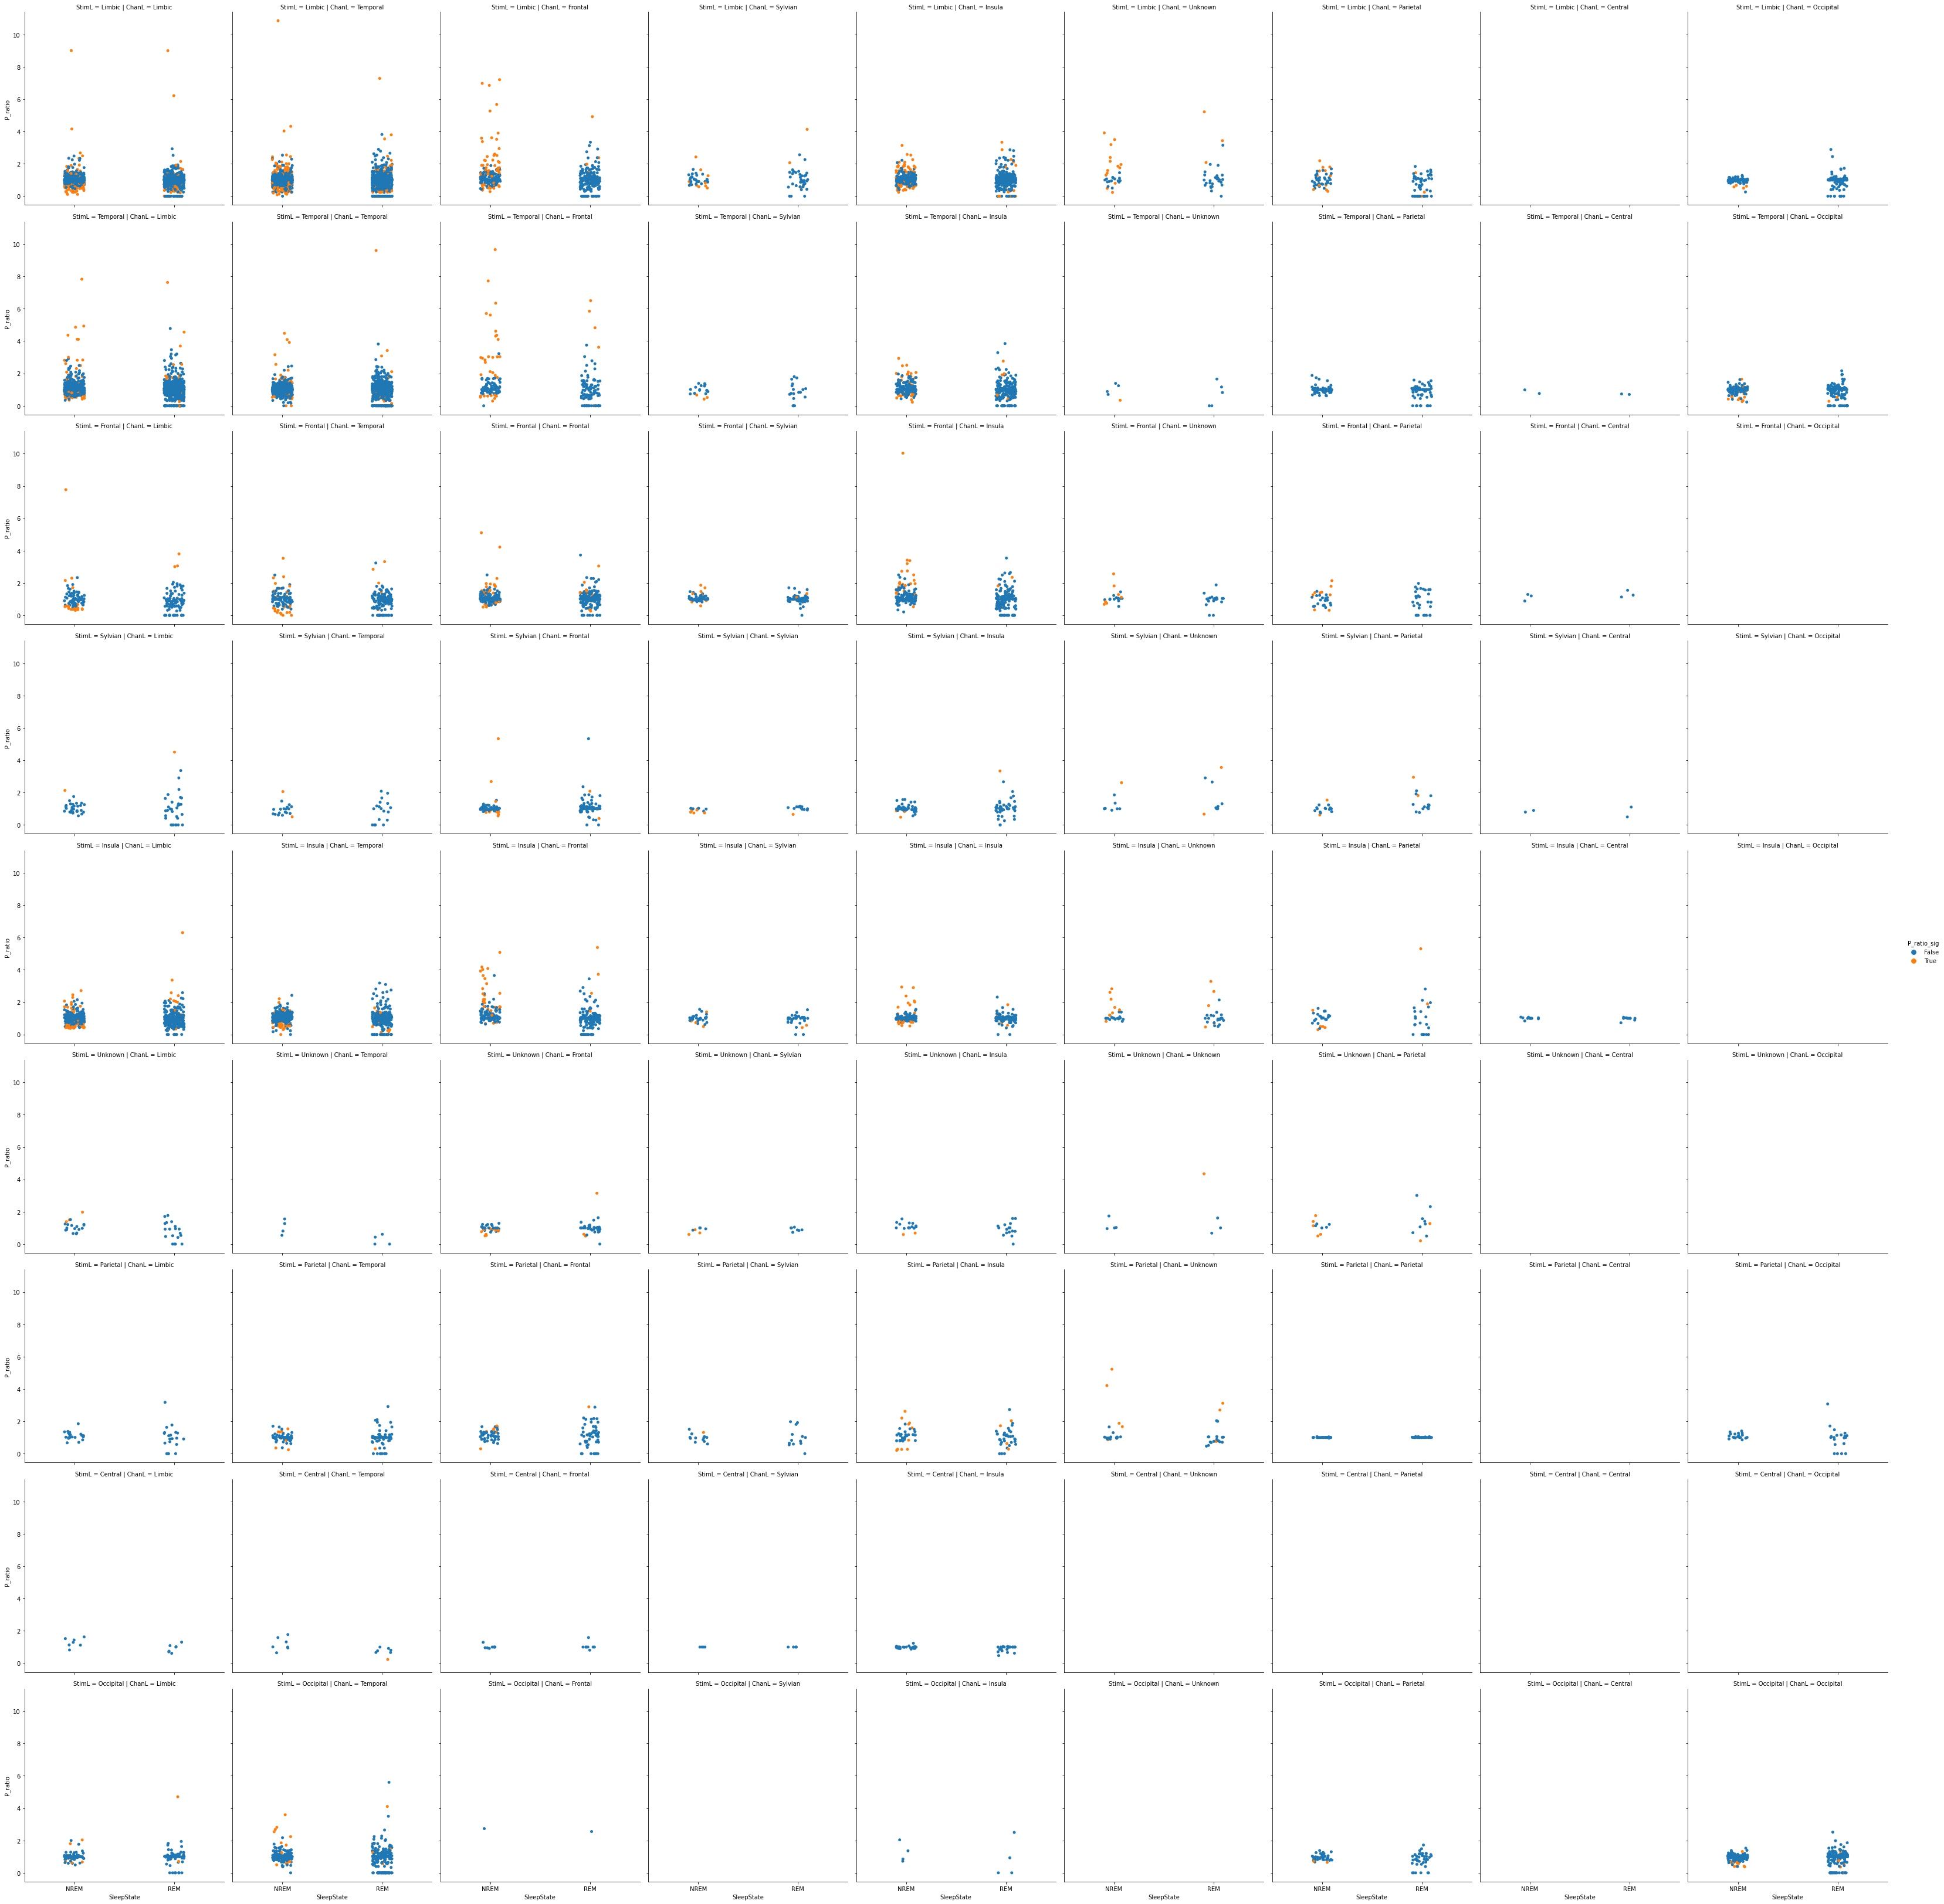

In [41]:
sns.catplot(x='SleepState', y= 'P_ratio', hue='P_ratio_sig',data=data_con[data_con.SleepState!='Wake'], row='StimL', col = 'ChanL')

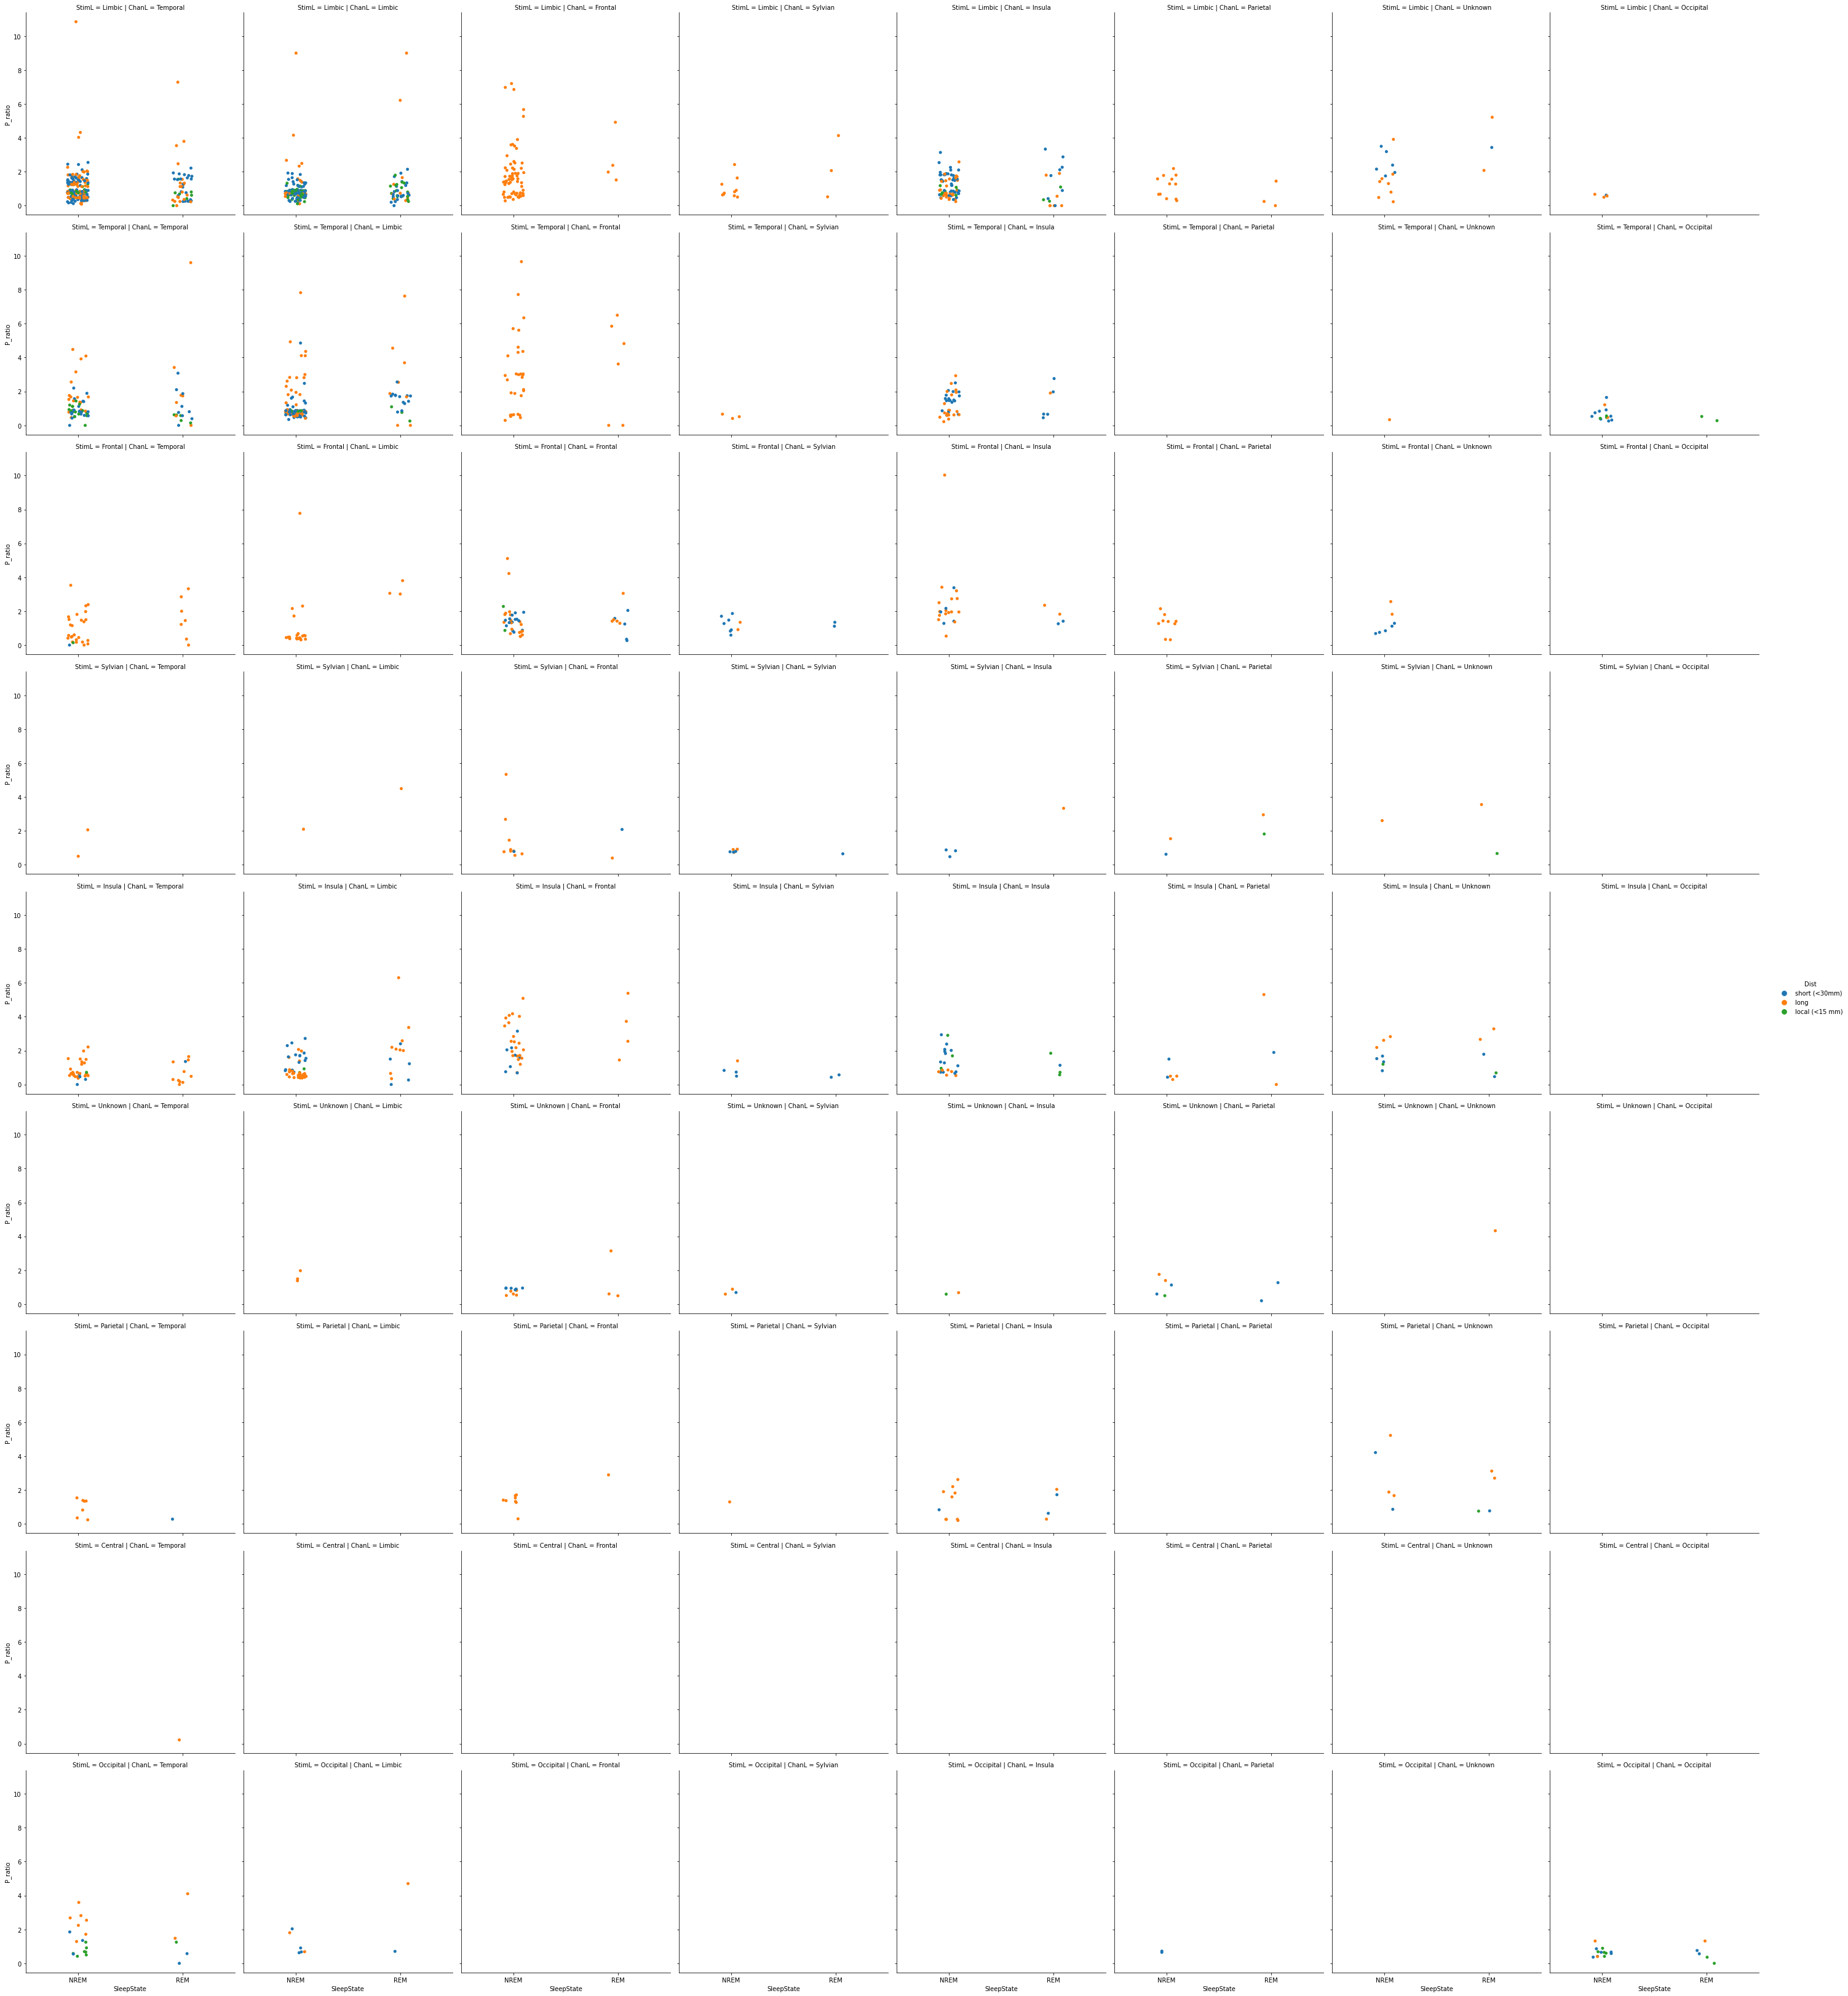

In [42]:
sns.catplot(x='SleepState', y= 'P_ratio', hue='Dist',data=data_con[data_con.P_ratio_sig==1], row='StimL', col = 'ChanL')

In [5]:
start

NameError: name 'start' is not defined

### NETWORK SLEEP

In [43]:
sleepstate_labels = ['NREM', 'REM']
r_order = ["Orbitofrontal", "Dorsofrontal", "Central", ' Cingular', 'Insula', 'Superotemporal', 'Laterotemporal',
           'Basotemporal', 'Mesiotemporal', 'Sylvian', 'Parietal', 'Occipital']

In [25]:
data_con

StimL     ChanL   Subj StimA ChanA          StimR           ChanR  \
0       Limbic    Limbic  EL019   Amy   Amy  Mesiotemporal   Mesiotemporal   
1       Limbic    Limbic  EL019   Amy   Amy  Mesiotemporal   Mesiotemporal   
2       Limbic    Limbic  EL019   Amy   Amy  Mesiotemporal   Mesiotemporal   
3       Limbic  Temporal  EL019   Amy   STG  Mesiotemporal  Laterotemporal   
4       Limbic  Temporal  EL019   Amy   STG  Mesiotemporal  Laterotemporal   
...        ...       ...    ...   ...   ...            ...             ...   
50328  Frontal   Frontal  EL017   SFS   IFS   Dorsofrontal    Dorsofrontal   
50329  Frontal   Frontal  EL017   SFS   IFS   Dorsofrontal    Dorsofrontal   
50330  Frontal   Frontal  EL017   SFS   SFS   Dorsofrontal    Dorsofrontal   
50331  Frontal   Frontal  EL017   SFS   SFS   Dorsofrontal    Dorsofrontal   
50332  Frontal   Frontal  EL017   SFS   SFS   Dorsofrontal    Dorsofrontal   

        Stim   Chan SleepState  H      Prob         LL            Dist  \
0        1.0    3.0       NREM  0  1.000000  11.659413  local (<15 mm)   
1        1.0    3.0        REM  0  1.000000  12.268156  local (<15 mm)   
2        1.0    3.0       Wake  0  0.987730   9.446486  local (<15 mm)   
3        1.0    8.0       NREM  0  0.621622   3.636706   short (<30mm)   
4        1.0    8.0        REM  0  0.800000   3.409969   short (<30mm)   
...      ...    ...        ... ..       ...        ...             ...   
50328  484.0  480.0        REM  0  1.000000   3.549227  local (<15 mm)   
50329  484.0  480.0       Wake  0  1.000000   4.296032  local (<15 mm)   
50330  484.0  482.0       NREM  0  1.000000   9.588881  local (<15 mm)   
50331  484.0  482.0        REM  0  1.000000   6.717892  local (<15 mm)   
50332  484.0  482.0       Wake  0  1.000000   7.940379  local (<15 mm)   

          LL_cd   P_ratio LL_cd_sig P_ratio_sig     d  
0      1.190153  1.012422      True       False   7.0  
1      1.512825  1.012422      True       False   7.0  
2      0.000000  1.000000       NaN         NaN   7.0  
3      0.060039  1.378562     False        True  24.5  
4     -0.150910  1.774150     False       False  24.5  
...         ...       ...       ...         ...   ...  
50328 -0.685965  1.000000     False       False  14.0  
50329  0.000000  1.000000       NaN         NaN  14.0  
50330  1.499568  1.000000      True       False   7.0  
50331 -1.338927  1.000000      True       False   7.0  
50332  0.000000  1.000000       NaN         NaN   7.0  

[50057 rows x 19 columns]

In [26]:
data_plot  = data_con[data_con.H ==0]
chan_ID = np.unique(np.concatenate([data_plot.Stim, data_plot.Chan])).astype('int')

In [38]:
##NODES
G = nx.empty_graph(len(chan_ID))
for i in range(len(chan_ID)):
    if len(data_plot.loc[data_plot.Stim == chan_ID[i], 'Subj'].values) > 0:
        G.nodes[i]["subj"] = data_plot.loc[data_plot.Stim == chan_ID[i], 'Subj'].values[0]
        G.nodes[i]["area"] = data_plot.loc[data_plot.Stim == chan_ID[i], 'StimA'].values[0]
        G.nodes[i]["region"] = data_plot.loc[data_plot.Stim == chan_ID[i], 'StimR'].values[0]
        G.nodes[i]["label"] = data_plot.loc[data_plot.Stim == chan_ID[i], 'StimA'].values[0]+'_'+str(i)
        G.nodes[i]["lobe"] = data_plot.loc[data_plot.Stim == chan_ID[i], 'StimL'].values[0]
    else:
        G.nodes[i]["subj"] = data_plot.loc[data_plot.Chan == chan_ID[i], 'Subj'].values[0]
        G.nodes[i]["area"] = data_plot.loc[data_plot.Chan == chan_ID[i], 'ChanA'].values[0]
        G.nodes[i]["region"] = data_plot.loc[data_plot.Chan == chan_ID[i], 'ChanR'].values[0]
        G.nodes[i]["label"] = data_plot.loc[data_plot.Chan == chan_ID[i], 'ChanA'].values[0]+'_'+str(i)
        G.nodes[i]["lobe"] = data_plot.loc[data_plot.Chan == chan_ID[i], 'ChanL'].values[0]



In [47]:
change_labels =['non', 'stable', 'decrease', 'increase']

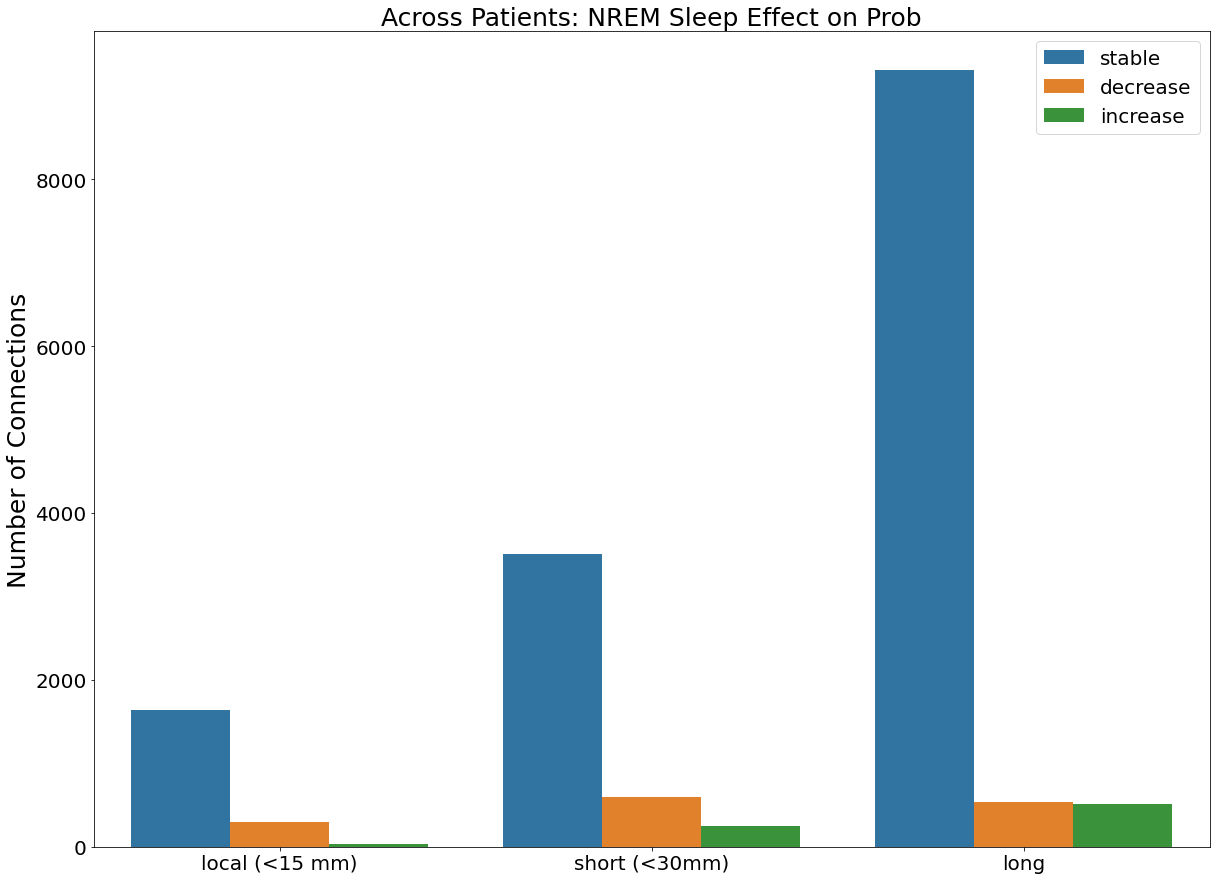

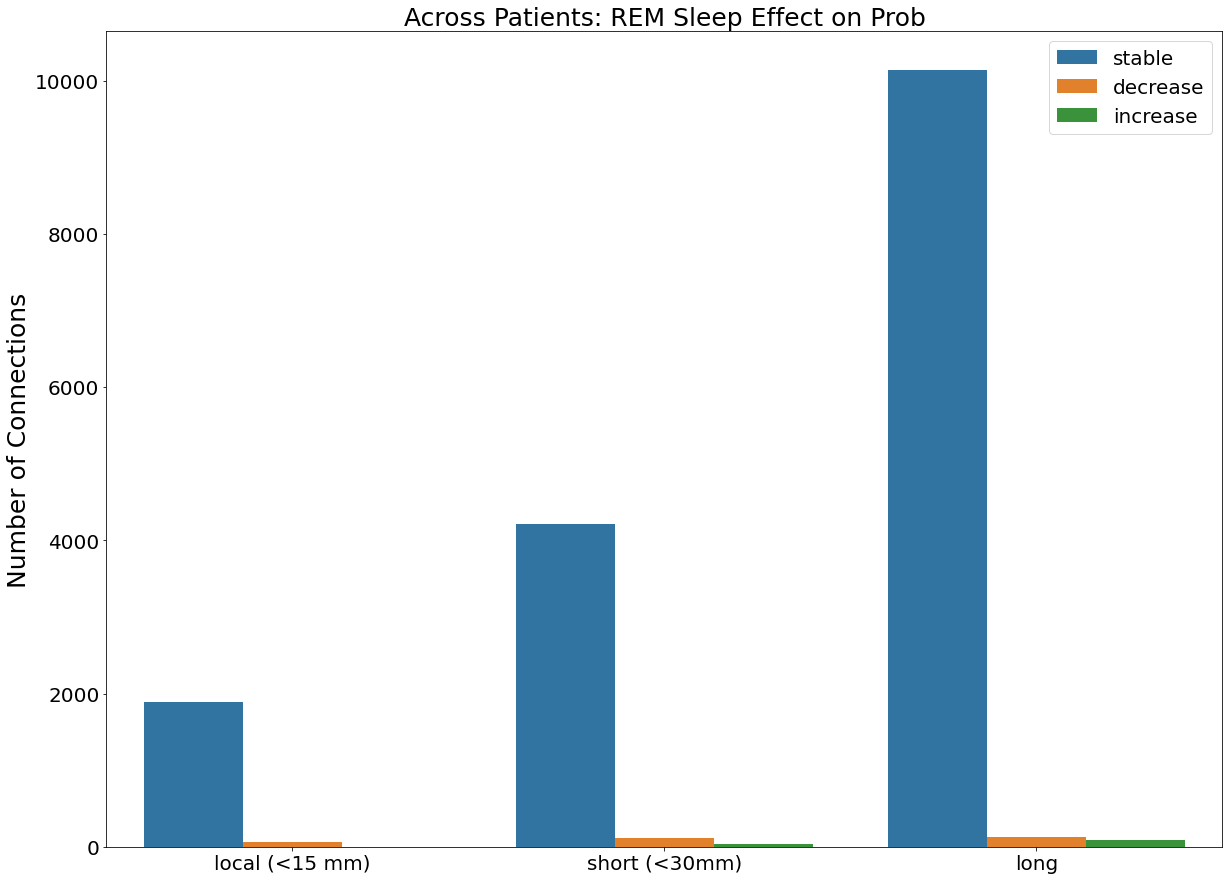

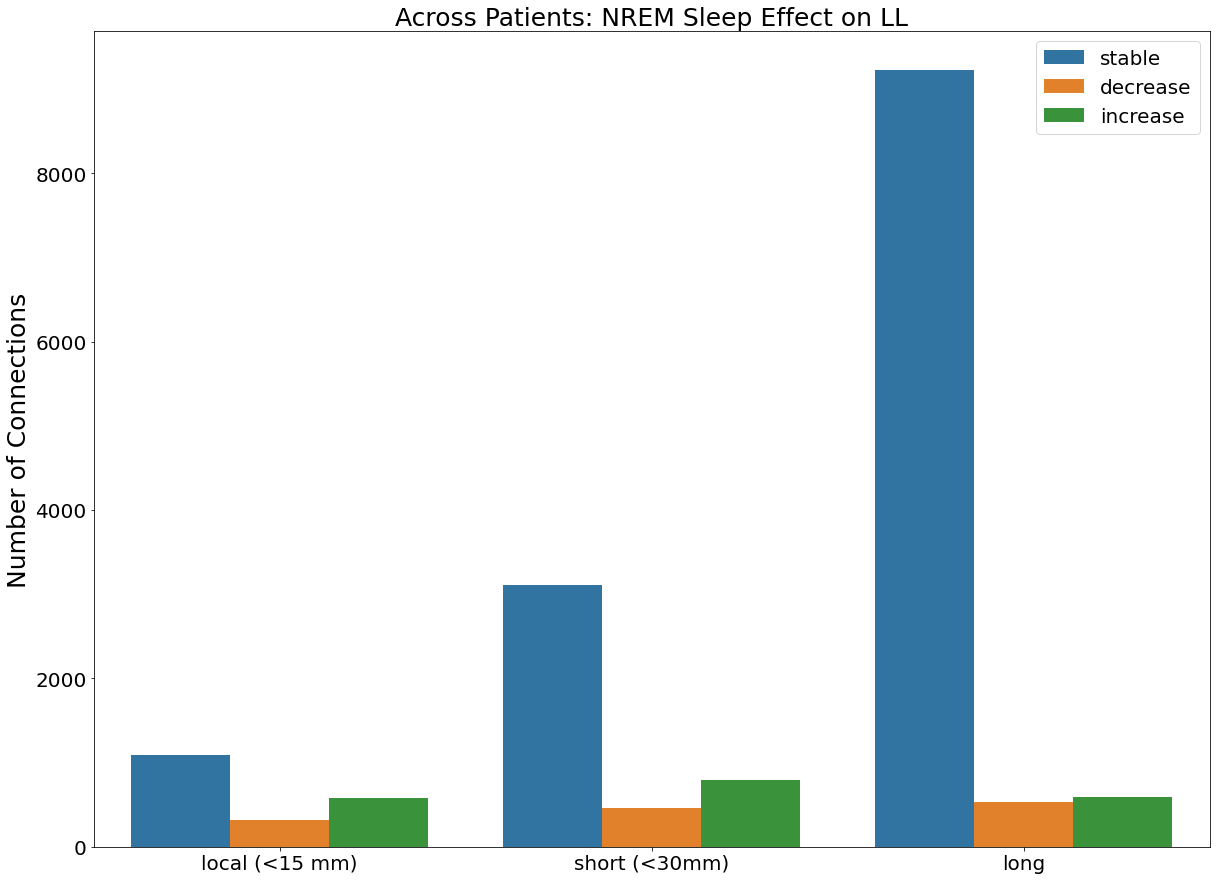

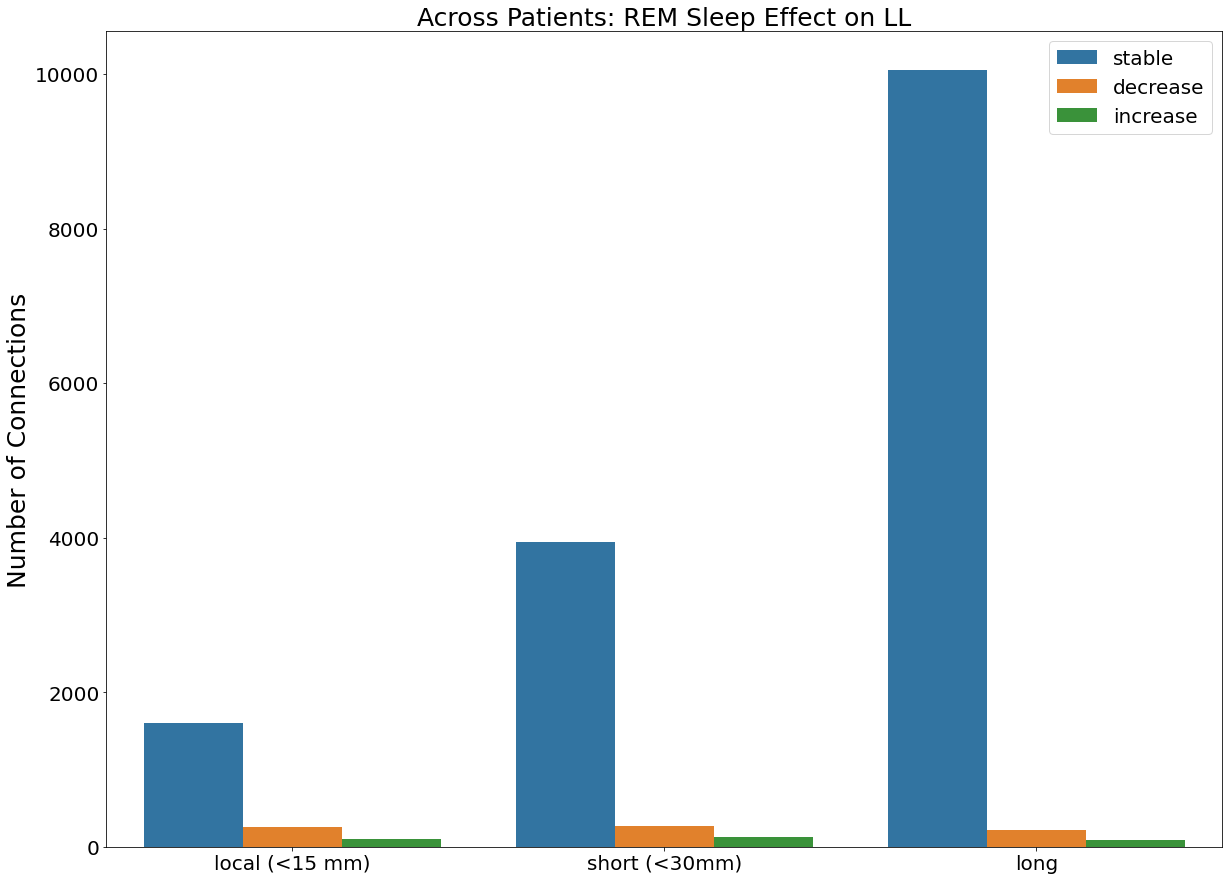

In [29]:
for test_label, test_label2 in zip(['prob_wake', 'ttest_wake'],['Prob', 'LL']): 
    for ss in ['NREM','REM']:
        plt.figure(figsize=(20, 15))
        plt.title('Across Patients: ' +ss + ' Sleep Effect on ' + test_label2, fontsize=25)
        sns.countplot(x='Dist', hue=test_label, data=data_con[data_con.SleepState == ss])
        plt.legend(['stable', 'decrease', 'increase'], fontsize=20)
        plt.ylabel('Number of Connections', fontsize=25)
        plt.xlabel('')
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.show()

Text(0.5, 1.0, 'NREM -- decrease')

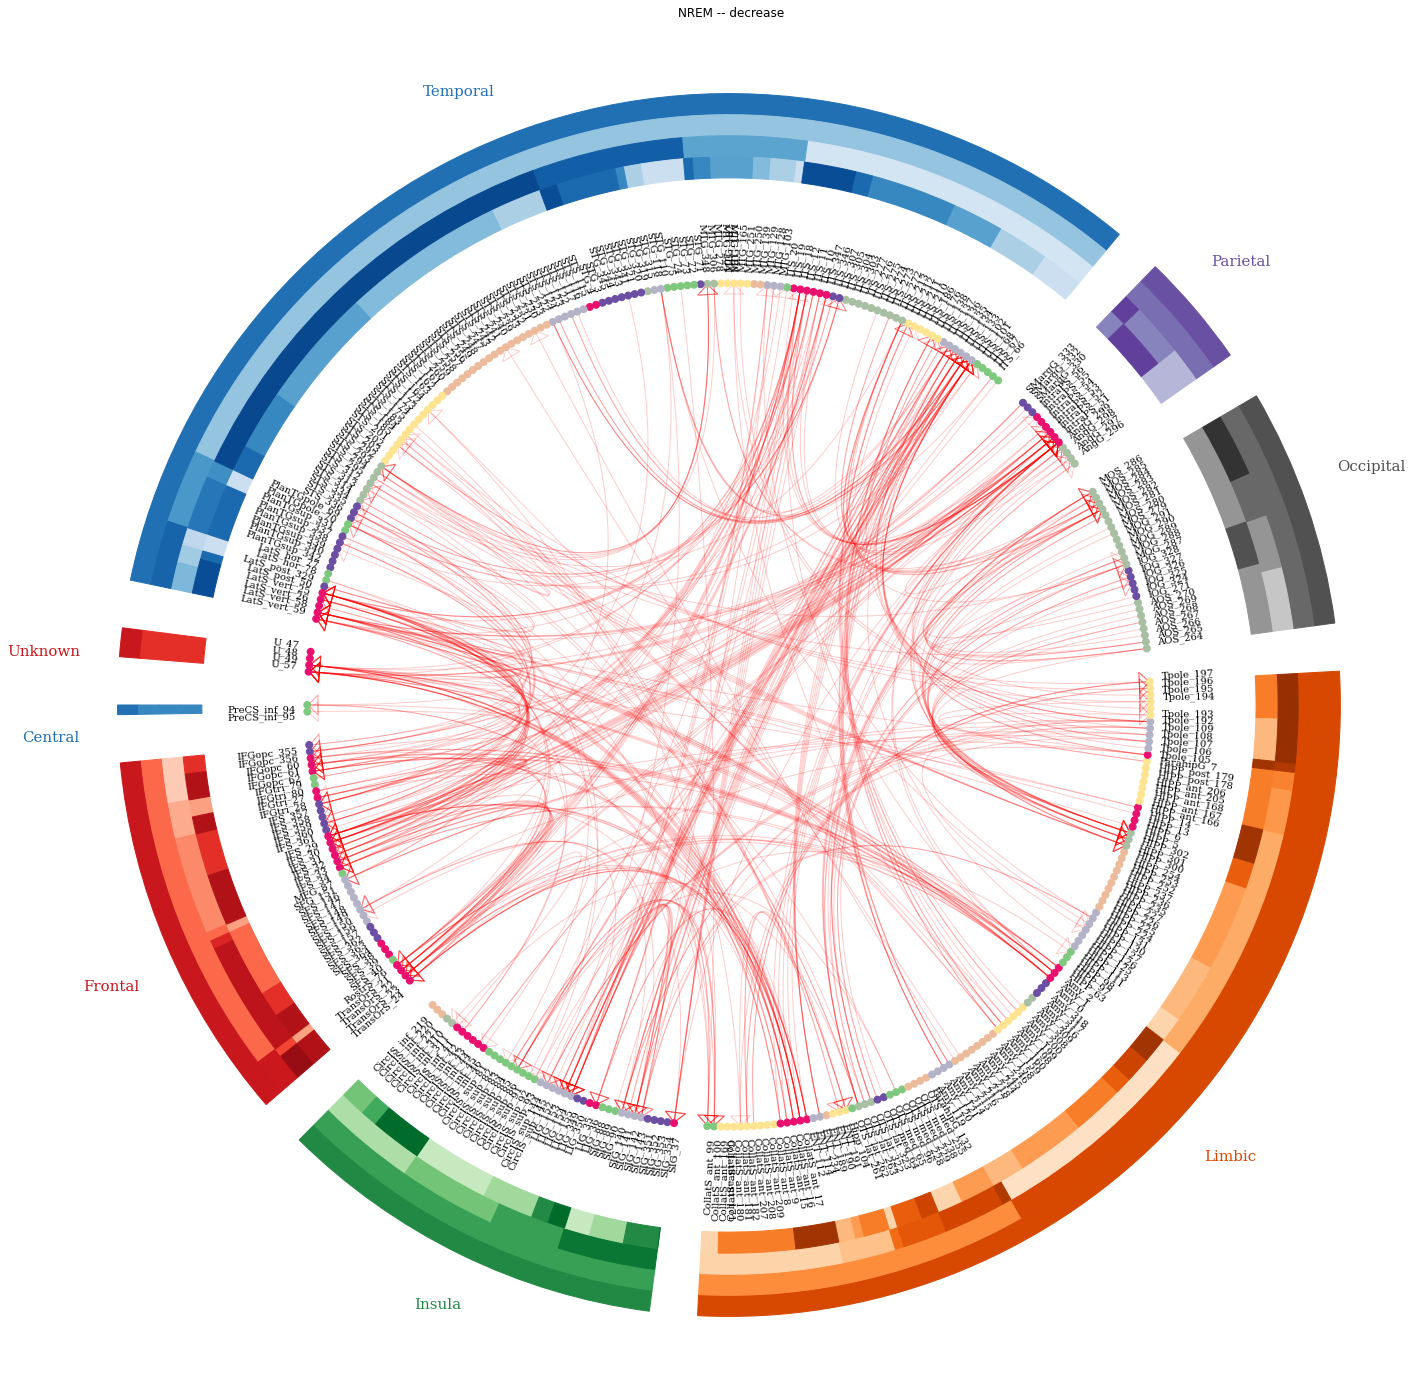

In [50]:
G.remove_edges_from(G.edges())
df_2_edges = data_plot[(data_plot.SleepState == ss)&(data_plot.SleepState == ss)&(data_plot['LL_cd_sig'] == 1)&(data_plot.LL_cd<0)&(data_plot.d>30)]
df_2_edges = df_2_edges.reset_index(drop=True)
for i in range(len(df_2_edges)): # 
    c = 'b'
    di = np.random.choice([0,1])
    G.add_edge(np.where(chan_ID == df_2_edges.Stim.values[i].astype('int'))[0][0],
               np.where(chan_ID == df_2_edges.Chan.values[i].astype('int'))[0][0], color=c, direction = di)

c = CircosPlot(
    G,
    node_grouping="lobe",
    node_subgrouping=["region", "area","subj"],
    node_color="subj",
    node_labels= True,
    node_label= 'label',
    group_label_position="middle",
    group_label_color=True,
    group_label_offset=65,
    figsize=(25,25), 
    fontsize=15
)
c.draw()
plt.title(ss+ ' -- decrease')

Text(0.5, 1.0, 'NREM -- increase')

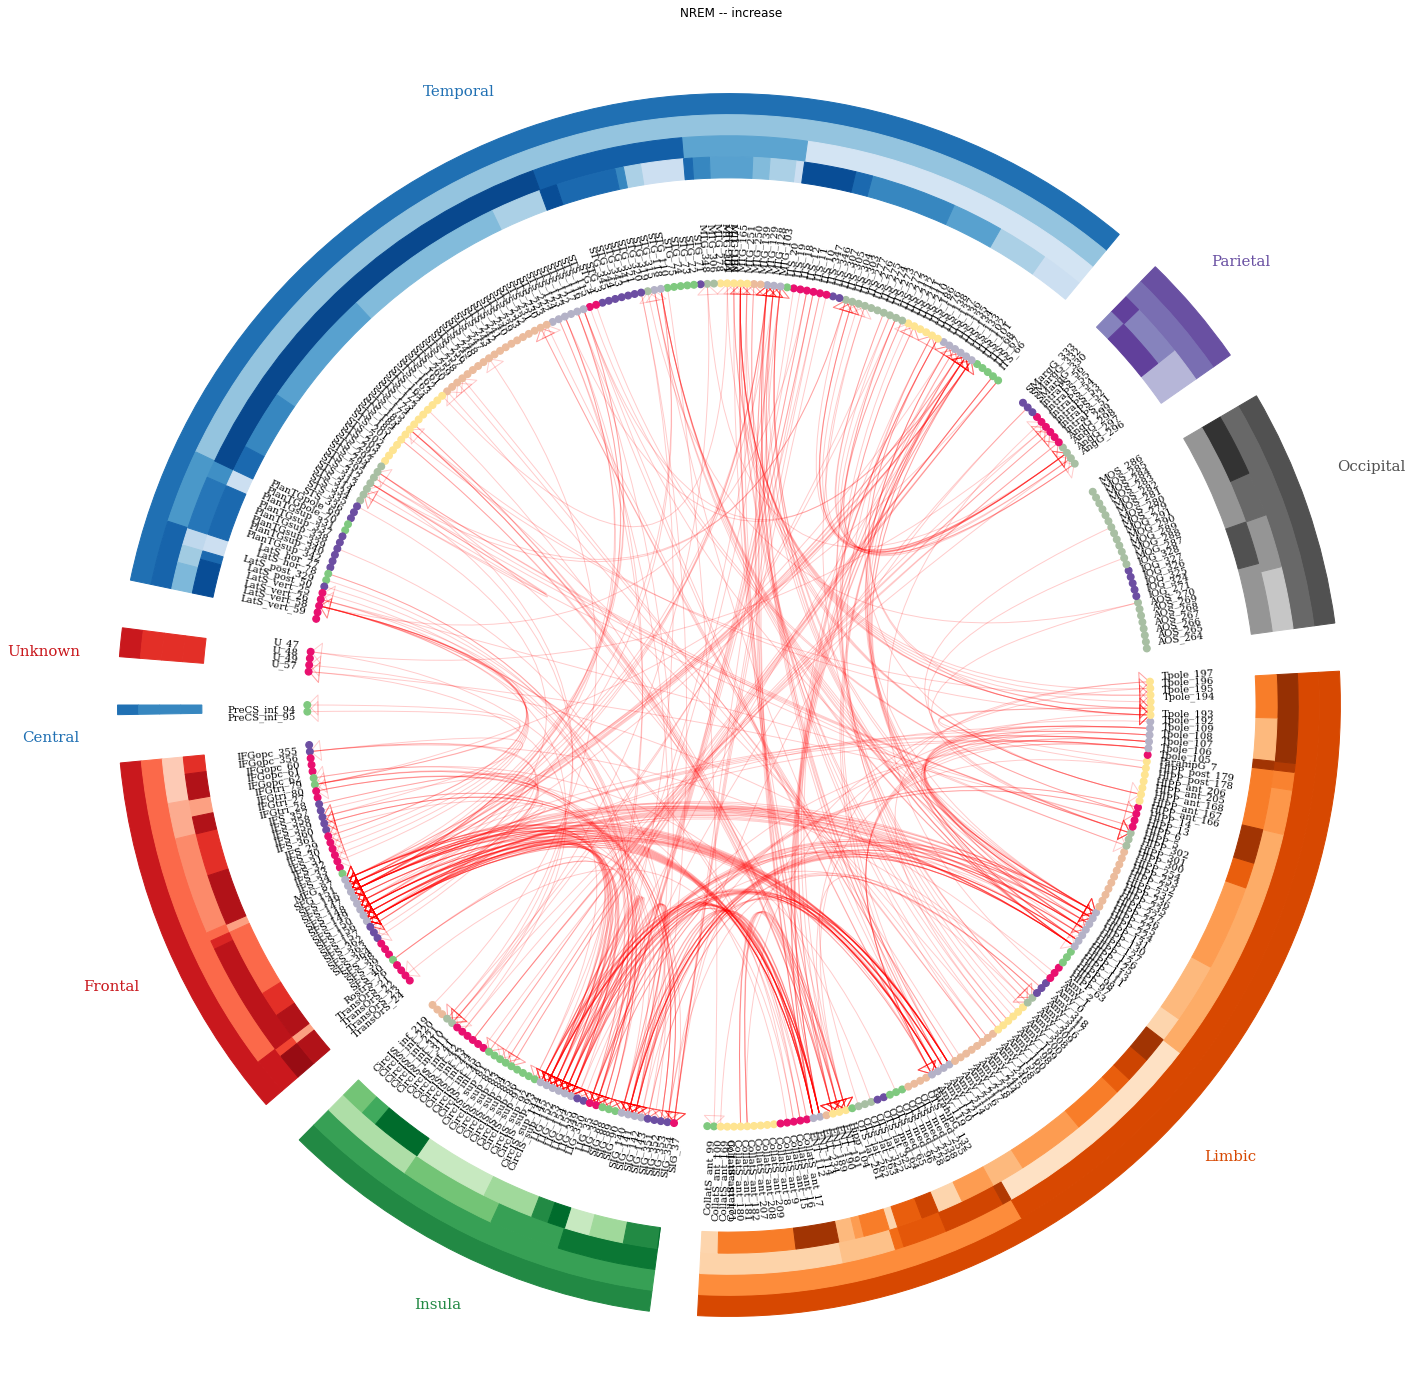

In [49]:
ss = 'NREM'

G.remove_edges_from(G.edges())
df_2_edges = data_plot[(data_plot.SleepState == ss)&(data_plot['LL_cd_sig'] == 1)&(data_plot.LL_cd>0)&(data_plot.d>30)]
df_2_edges = df_2_edges.reset_index(drop=True)
for i in range(len(df_2_edges)): # 
    c = 'b'
    di = np.random.choice([0,1])
    G.add_edge(np.where(chan_ID == df_2_edges.Stim.values[i].astype('int'))[0][0],
               np.where(chan_ID == df_2_edges.Chan.values[i].astype('int'))[0][0], color=c, direction = di)

c = CircosPlot(
    G,
    node_grouping="lobe",
    node_subgrouping=["region","area","subj"],
    node_color="subj",
    node_labels= True,
    node_label= 'label',
    group_label_position="middle",
    group_label_color=True,
    group_label_offset=65,
    figsize=(25,25), 
    fontsize=15
)
c.draw()
plt.title(ss+ ' -- increase')

In [15]:
## edges
for test_label, test_label2 in zip(['prob_wake', 'ttest_wake'],['Prob', 'LL']): 
    for ss in ['NREM','REM']:
        for change in [2,3]:

            G.remove_edges_from(G.edges())
            df_2_edges = data_plot[(data_plot.SleepState == ss)&(data_plot[test_label] == change)&(data_plot.d < 30)]
            df_2_edges = df_2_edges.reset_index(drop=True)
            for i in range(len(df_2_edges)): # 
                c = 'b'
                di = np.random.choice([0,1])
                G.add_edge(np.where(chan_ID == df_2_edges.Stim.values[i].astype('int'))[0][0],
                           np.where(chan_ID == df_2_edges.Chan.values[i].astype('int'))[0][0], color=c, direction = di)
                
            c = CircosPlot(
                G,
                node_grouping="region",
                node_subgrouping=["area","subj"],
                node_color="subj",
                node_labels= True,
                node_label= 'label',
                group_label_position="middle",
                group_label_color=True,
                group_label_offset=65,
                figsize=(25,25), 
                fontsize=15
            )
            c.draw()
            plt.title(test_label2+' '+change_labels[change]+' in '+ss+', short connections')
            plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\Sleep\connectogram\\figures\\'+test_label2+'_'+change_labels[change]+'_'+ss+'_short.svg')
            plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\Sleep\connectogram\\figures\\'+test_label2+'_'+change_labels[change]+'_'+ss+'_short.jpg')
            plt.close()
## edges
for test_label, test_label2 in zip(['prob_wake', 'ttest_wake'],['Prob', 'LL']):
    
    for ss in ['NREM','REM']:
        for change in [2,3]:

            G.remove_edges_from(G.edges())
            df_2_edges = data_plot[(data_plot.SleepState == ss)&(data_plot[test_label] == change)&(data_plot.d > 30)]
            df_2_edges = df_2_edges.reset_index(drop=True)
            for i in range(len(df_2_edges)): # 
                c = 'b'
                di = np.random.choice([0,1])
                G.add_edge(np.where(chan_ID == df_2_edges.Stim.values[i].astype('int'))[0][0],
                           np.where(chan_ID == df_2_edges.Chan.values[i].astype('int'))[0][0], color=c, direction = di)
                
            c = CircosPlot(
                G,
                node_grouping="region",
                node_subgrouping=["area","subj"],
                node_color="subj",
                node_labels= True,
                node_label= 'label',
                group_label_position="middle",
                group_label_color=True,
                group_label_offset=65,
                figsize=(25,25), 
                fontsize=15
            )
            c.draw()
            plt.title(test_label2+' '+change_labels[change]+' in '+ss+', long connections')
            
            plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\Sleep\connectogram\\figures\\'+test_label2+'_'+change_labels[change]+'_'+ss+'_long.svg')
            plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\Sleep\connectogram\\figures\\'+test_label2+'_'+change_labels[change]+'_'+ss+'_long.jpg')
            plt.close()

In [ ]:
stop

In [ ]:
sns.scatterplot(x='d', y='Prob', hue='ttest_wake', data= data_plot_P[data_plot_P.SleepState=='NREM'])

In [ ]:
sns.scatterplot(x='d', y='Prob', hue='Subj', data= data_plot_P[data_plot_P.SleepState=='NREM'])

In [ ]:
sns.scatterplot(x='d', y='Prob', hue='Subj', data= data_plot_P[data_plot_P.SleepState=='NREM'])

In [ ]:
sns.catplot( x= 'Dist', hue='prob_wake', data= data_plot_P, kind='count', row='ChanR')

In [ ]:
sns.catplot( x= 'Dist', hue='prob_wake', data= data_plot_P, kind='count', row='ChanR')

## CIRCOS

In [ ]:
t_show = 0
test = 'Prob'
tt = 'prob_wake'

if t_show == 1:
    test = 'LL'
    tt = 'ttest_wake'

In [ ]:
ss = 0
df_2 = data_con[data_con.SleepState == sleepstate_labels[ss]]
chan_ID = np.unique(np.concatenate([df_2.Stim, df_2.Chan])).astype('int')

In [ ]:
i = 0
lobe = df_2.loc[df_2.Stim == chan_ID[i], 'StimR'].values[0]
par = df_2.loc[df_2.Stim == chan_ID[i], 'StimA'].values[0] + '_' + str(chan_ID[i])
z1 = str(float(df_2.loc[df_2.Stim == chan_ID[i], 'Subj'].values[0][-2:]) / 100)
Map = pd.DataFrame([[lobe, par, '0', '0', '0', z1, z1, z1, z1]],
                   columns=['region', 'parcelation', 'r', 'g', 'b', 'z1', 'z2', 'z3', 'z4'])

In [ ]:
for i in range(1, len(chan_ID)):
    if len(df_2.loc[df_2.Stim == chan_ID[i], 'Subj'].values) > 0:
        lobe = df_2.loc[df_2.Stim == chan_ID[i], 'StimR'].values[0]
        par = df_2.loc[df_2.Stim == chan_ID[i], 'StimA'].values[0] + '_' + str(chan_ID[i])
        z1 = float(df_2.loc[df_2.Stim == chan_ID[i], 'Subj'].values[0][-2:]) / 100
    else:
        lobe = df_2.loc[df_2.Chan == chan_ID[i], 'ChanR'].values[0]
        par = df_2.loc[df_2.Chan == chan_ID[i], 'ChanA'].values[0] + '_' + str(chan_ID[i])
        z1 = str(float(df_2.loc[df_2.Chan == chan_ID[i], 'Subj'].values[0][-2:]) / 100)
    Map_row = pd.DataFrame([[lobe, par, '0', '0', '0', z1, z1, z1, z1]],
                           columns=['region', 'parcelation', 'r', 'g', 'b', 'z1', 'z2', 'z3', 'z4'])

    Map = pd.concat([Map, Map_row])
Map = Map.reset_index(drop=True)
Map = Map.sort_values(by="parcelation")
Map = Map.reset_index(drop=True)
Map['region'] = pd.Categorical(Map['region'], r_order)
Map = Map.sort_values(by="region")
Map = Map.reset_index(drop=True)
lobes = np.unique(Map.region)

In [ ]:
path_map = 'Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\Sleep\connectogram\\' +sleepstate_labels[ss] + '\\' + test + '\\raw/map.txt'
with open(path_map, 'a') as f:
    dfAsString = Map.to_string(header=False, index=False)
    f.write(dfAsString)

##### Edges

In [ ]:
path_links = 'Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\Sleep\connectogram\\' +sleepstate_labels[ss] + '\\' + test + '\\raw/map.links.txt'

In [ ]:
i = 0
df_2 = df_2[df_2[tt] > 1]
p1 = df_2.StimA.values[i] + '_' + str(int(df_2.Stim.values[i]))
p2 = df_2.ChanA.values[i] + '_' + str(int(df_2.Chan.values[i]))
score = df_2[tt].values[i]
t = 0
h = 'l'
if score == 3:
    t = 1
    h = 'r'

M_links = pd.DataFrame([[h, p1, h, p2, str(t), str(score)]], columns=['h1', 'p1', 'h2', 'p2', 'type', 'score'])

In [ ]:
for i in range(1, len(df_2)):
    p1 = df_2.StimA.values[i] + '_' + str(int(df_2.Stim.values[i]))
    p2 = df_2.ChanA.values[i] + '_' + str(int(df_2.Chan.values[i]))
    score = df_2[tt].values[i]
    t = 0
    h = 'l'
    if score == 3:
        t = 1
        h = 'r'
    M_links_new = pd.DataFrame([[h, p1, h, p2, str(t), str(score)]], columns=['h1', 'p1', 'h2', 'p2', 'type', 'score'])
    M_links = pd.concat([M_links, M_links_new])
M_links = M_links.reset_index(drop=True)

In [ ]:
with open(path_links, 'a') as f:
    dfAsString = M_links.to_string(header=False, index=False)
    f.write(dfAsString)

### heatmap

In [ ]:
t_show = 0
test = 'Prob'
tt = 'prob_wake'

In [ ]:
for t_show in range(2):
    if t_show == 1:
        test = 'LL'
        tt = 'ttest_wake'
    for ss in range(2):
        plt.figure(figsize=(20, 15))
        plt.title('Across Patients: ' + sleepstate_labels[ss] + ' Sleep Effect on ' + test, fontsize=25)
        sns.countplot(x='Dist', hue=tt, data=data_con[data_con.SleepState == sleepstate_labels[ss]])
        plt.legend(['stable', 'decrease', 'increase'], fontsize=20)
        plt.ylabel('Number of Connections', fontsize=25)
        plt.xlabel('')
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.show()

In [ ]:
t_show = 0
test = 'Prob'
tt = 'prob_wake'

if t_show == 1:
    test = 'LL'
    tt = 'ttest_wake'

In [ ]:
e_val = 3
e = 'increase'
if e_val == 2:
    e = 'decrease'
if e_val == 1:
    e = 'no'

In [ ]:
data_con_sig = data_con[(data_con[tt] == e_val) & (data_con.SleepState == sleepstate_labels[ss])]
df = data_con_sig.groupby(['StimR', 'ChanR'], as_index=False)[[tt]].count()
df[tt] = np.round(df[tt], 2)
df_p = df.pivot("StimR", "ChanR", tt)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))  # mask

fig.patch.set_facecolor('xkcd:black')
plt.title(e + ' ' + sleepstate_labels[ss] + ' Sleep Effect on ' + test, fontsize=25, color=[1, 1, 1])
g = sns.heatmap(df_p, annot=True, cmap='hot', vmin=0)
g.set_facecolor('xkcd:black')

plt.ylabel('A', fontsize=20, color="white")
plt.xlabel('B', fontsize=20, color="white")
plt.yticks(fontsize=15, color="white")
plt.xticks(fontsize=15, color="white", rotation=90)
plt.show()

## Networkx Visualization

#### DiGraph

In [ ]:
G = nx.DiGraph()
for i in range(len(chan_ID)):
    if len(df_2.loc[df_2.Stim == chan_ID[i], 'Subj'].values) > 0:
        G.add_node(chan_ID[i], subj=df_2.loc[df_2.Stim == chan_ID[i], 'Subj'].values[0],
                   area=df_2.loc[df_2.Stim == chan_ID[i], 'StimA'].values[0],
                   region=df_2.loc[df_2.Stim == chan_ID[i], 'StimR'].values[0])
    else:
        G.add_node(chan_ID[i], subj=df_2.loc[df_2.Chan == chan_ID[i], 'Subj'].values[0],
                   area=df_2.loc[df_2.Chan == chan_ID[i], 'ChanA'].values[0],
                   region=df_2.loc[df_2.Chan == chan_ID[i], 'StimA'].values[0])

In [ ]:
for i in range(len(df_2)):
    G.add_edge(df_2.Stim.values[i].astype('int'), df_2.Chan.values[i].astype('int'),
               weight=df_2.Dir_index.values[i].astype('int'))

#### complete GRaph

In [ ]:
ss = 0
df_2 = data_con[data_con.SleepState == sleepstate_labels[ss]]
chan_ID = np.unique(np.concatenate([df_2.Stim, df_2.Chan])).astype('int')
df_2 = df_2.reset_index(drop=True)

In [ ]:
G = nx.empty_graph(len(chan_ID))
for i in range(len(chan_ID)):
    if len(df_2.loc[df_2.Stim == chan_ID[i], 'Subj'].values) > 0:
        G.nodes[i]["subj"] = df_2.loc[df_2.Stim == chan_ID[i], 'Subj'].values[0]
        G.nodes[i]["area"] = df_2.loc[df_2.Stim == chan_ID[i], 'StimA'].values[0]
        G.nodes[i]["region"] = df_2.loc[df_2.Stim == chan_ID[i], 'StimR'].values[0]
    else:
        G.nodes[i]["subj"] = df_2.loc[df_2.Chan == chan_ID[i], 'Subj'].values[0]
        G.nodes[i]["area"] = df_2.loc[df_2.Chan == chan_ID[i], 'ChanA'].values[0]
        G.nodes[i]["region"] = df_2.loc[df_2.Chan == chan_ID[i], 'ChanR'].values[0]

In [ ]:
df_2_edges = df_2[df_2.prob_wake>1]
df_2_edges = df_2_edges.reset_index(drop=True)

In [ ]:
for i in range(len(df_2_edges)):
    c = 'b'
    if df_2_edges.prob_wake.values[i].astype('int') ==3:
        c = 'r'
    G.add_edge(np.where(chan_ID == df_2_edges.Stim.values[i].astype('int'))[0][0],
               np.where(chan_ID == df_2_edges.Chan.values[i].astype('int'))[0][0],
               weight=df_2_edges.prob_wake.values[i].astype('int'), color=c)

In [ ]:
import sys
sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis\visualization')

In [ ]:
### The required libraries and packages ###
import networkx as nx
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nxviz
from nxviz.plots_cust import CircosPlot, MatrixPlot, ArcPlot, BasePlot

In [ ]:
node_grouping = 'region'
node_order = ['area', 'subj']
grouping_all = node_order.copy()
grouping_all.insert(0, node_grouping)

nodes = [n for n, d in sorted(G.nodes(data=True), key =lambda x: [x[1] [grouping_all[n]] for n in range(len(grouping_all))])]

In [ ]:
from collections import Counter

In [ ]:
data = [G.nodes[n]['region'] for n in G.nodes]
node_length = len(data)
groups = Counter(data)

In [ ]:
data = [G.nodes[n][grouping_all[1]] for n in nodes]

In [ ]:
data_unique= np.unique(data)

In [ ]:
vec = np.array(np.array(data) == data_unique[0])*1

In [ ]:
import  itertools 

## plot subgroups

In [ ]:
self.grapj = G 

In [ ]:
node_grouping

In [ ]:
nodes # sle.fnodes (nodes numbers order by correct order)
grouping_all #['region', 'area', 'subj']
regions = [G.nodes[n][node_grouping] for n in nodes]

In [ ]:
np.unique(regions)[5]

In [ ]:
reg = 6 # first region
group_type = 0 # first subgroup
SG = G.subgraph([n for n, attrdict in G.nodes.items() if
                                          attrdict[node_grouping] == np.unique(regions)[reg]])
SG_nodes = [n for n, d in sorted(SG.nodes(data=True),
                                              key=lambda x: [x[1][grouping_all[n]] for n in range(len(grouping_all))])]

data = [SG.nodes[n][grouping_all[1]] for n in SG_nodes] #different subroup labels
data_unique = np.unique(data) # subgroup labels, unique
data_unique

In [ ]:
nodes_arr = np.array(nodes)

In [ ]:
nodes.shape

In [ ]:
np.isin(nodes,SG_nodes)

In [ ]:
SG_nodes

In [ ]:
for sg in range(len(data_unique)):
    vec = np.array(np.array(data) == data_unique[sg]) * 1
    seqs = [(key, len(list(val))) for key, val in itertools.groupby(vec)]
    # find start positions of sequences
    # seqs = [(key, start, length), ...]
    seqs = [(key, sum(s[1] for s in seqs[:i]), len) for i, (key, len) in enumerate(seqs)]
    ix = np.array([[s[1], s[1] + s[2]] for s in seqs if s[0] == 1])
    ix[ix >= len(SG_nodes)] = len(SG_nodes) - 1
    for i in range(len(ix)):
        node_start = SG_nodes[ix[i, 0]]
        node_end = SG_nodes[ix[i, 1]]
        print(node_start, node_end)

In [ ]:
SG_nodes

In [ ]:
SG_nodes[ix[0,1]]

In [ ]:
ix

In [ ]:
sg = 4
vec = np.array(np.array(data) == data_unique[sg]) * 1
seqs = [(key, len(list(val))) for key, val in itertools.groupby(vec)]
# find start positions of sequences
# seqs = [(key, start, length), ...]
seqs = [(key, sum(s[1] for s in seqs[:i]), len) for i, (key, len) in enumerate(seqs)]
ix = np.array([[s[1], s[1] + s[2]] for s in seqs if s[0] == 1])
ix

In [ ]:
ix

In [ ]:
SG_nodes

In [ ]:
seqs = [(key, len(list(val))) for key, val in itertools.groupby(vec)]
# find start positions of sequences
# seqs = [(key, start, length), ...]
seqs = [(key, sum(s[1] for s in seqs[:i]), len) for i, (key, len) in enumerate(seqs)]
ix = np.array([[s[1], s[1] + s[2] - 1] for s in seqs if s[0] == 1])

In [ ]:
ix = np.where(nodes_dummies == -1)[0]
ix = np.insert(ix, 0, -1)
ix = np.sort(np.insert(ix, -1, len(nodes_dummies)+1))
ix = np.reshape(ix, (-1, 2))
ix[:, 1] = ix[:, 1] -1
ix[:,0] = ix[:, 0] +1

In [ ]:
for i in range(2):
    c = 'b'
    if df_2_edges.prob_wake.values[i].astype('int') ==3:
        c = 'r'
    G.add_edge(np.where(chan_ID == df_2_edges.Stim.values[i].astype('int'))[0][0],
               np.where(chan_ID == df_2_edges.Chan.values[i].astype('int'))[0][0],
               weight=df_2_edges.prob_wake.values[i].astype('int'), color=c)

In [ ]:
for i, (start, end) in enumerate(G.edges()):
    print(i, (start, end))

In [ ]:
for i in range(len(ix)-1):
    node_start = nodes_dummies[ix[i, 0]]
    node_end =nodes_dummies[ix[i, 1]]
    print(node_start)
    print(node_end)

In [ ]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return np.array(tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3)))/256

In [ ]:
hex_to_rgb(sns.color_palette('Blues', 2).as_hex()[0])

In [ ]:
sns.color_palette('Blues', 2).as_hex()[:]

In [ ]:
G.nodes.items()

In [ ]:
SG = G.subgraph( [n for n,attrdict in G.nodes.items() if attrdict ['region'] == 'Mesiotemporal'])

In [ ]:
SG.nodes()

In [ ]:
SG.nodes()

In [ ]:
G.nodes(data=True)

In [ ]:

c = CircosPlot(
    G,
    node_grouping="region",
    node_color="region",
    node_order="region",
    node_labels=True,
    group_label_position="middle",
    group_label_color=True,
    group_label_offset=6,
    figsize=(20, 20)
)
c.draw()
plt.show()

In [ ]:
def make_graph(nodes_df, edges_df):
    # make graph from nodes and edges
    g = nx.DiGraph()
    for i, row in nodes_df.iterrows():
        keys = row.index.tolist()

        values = row.values

        # The dict contains all attributes

        g.add_node(row['ID'], **dict(zip(keys, values)))

    for i, row in edges_df.iterrows():
        keys = row.index.tolist()

        values = row.values

        g.add_edge(row['source'], row['target'], weight=row['LL_peak'], **dict(zip(keys, values)))

    return g

###  testing functions for nxviz

In [ ]:
circos_radius(10, 20)

In [ ]:
def circos_radius(n_nodes, node_r):
    """
    Automatically computes the origin-to-node centre radius of the Circos plot
    using the triangle equality sine rule.

    a / sin(A) = b / sin(B) = c / sin(C)

    :param n_nodes: the number of nodes in the plot.
    :type n_nodes: int
    :param node_r: the radius of each node.
    :type node_r: float
    :returns: Origin-to-node centre radius.
    """
    A = 2 * np.pi / n_nodes  # noqa
    B = (np.pi - A) / 2  # noqa
    a = 2 * node_r
    return a * np.sin(B) / np.sin(A)